## Autoencoder

In [34]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, explained_variance_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization

* Loss: 학습 데이터에서의 오차
* Val_loss: 검증 데이터에서의 오차

* Loss 감소 = 오차 감소 = 예측 정확도 향상

과적합시 일반적으로:

Loss: 매우 낮음 (암기한 문제는 잘 풂)  
Val_loss: 매우 높음 (새로운 문제는 못 풂)  

따라서 Val_loss가 Loss보다 낮다는 것은 모델이 암기가 아닌 진짜 이해를 했다는 의미

In [35]:
# 변수 설정

a_latent_dim = 5
a_epoch = 200
a_batch_size = 32
a_kernel = 3
a_dilation_rate = 1
a_window_size = 7
a_dropout_rate = 0.1
a_patience = 20
a_detail_level = 'high'
a_learning_rate = 0.001



#### 1) 데이터 준비

In [36]:
def prepare_data(df):
    """
    데이터를 TCN Autoencoder에 입력하기 위한 형태로 전처리합니다.
    
    Args:
        df (pandas.DataFrame): 원본 데이터프레임 (columns: ['idx', 'age', 'name', 'score', 'date'])
    
    Returns:
        numpy.ndarray: 시계열 윈도우 형태로 변환된 데이터 [샘플 수, 윈도우 크기, 특성(연령대) 수]
    """
    # 날짜와 연령대를 기준으로 피벗 테이블 생성 (행: 날짜, 열: 연령대, 값: score)
    pivot_df = df.pivot(index='date', columns='age', values='score')
    
    # 결측값이 있다면 이전 값으로 채움
    pivot_df = pivot_df.ffill()
    
    # 스케일링 추가
    scaler = StandardScaler()  # 또는 MinMaxScaler()
    scaled_data = scaler.fit_transform(pivot_df.values)
    

	# 윈도우 생성
    def create_windows(data, window_size= a_window_size):
        """
        시계열 데이터를 윈도우 형태로 변환합니다.
        
        Args:
            data (numpy.ndarray): 입력 시계열 데이터
            window_size (int): 윈도우 크기 (기본값: 7일)
            
        Returns:
            numpy.ndarray: 윈도우 형태로 변환된 데이터
        """
        windows = []
        # 데이터를 윈도우 크기만큼 슬라이딩하며 샘플 생성
        for i in range(len(data) - window_size + 1):
            windows.append(data[i:i+window_size])
        return np.array(windows)
    
    return create_windows(scaled_data, window_size= a_window_size), scaler



#### 2) TCN 기본 블록 생성

In [37]:
def tcn_block(inputs, n_filters, kernel_size, dilation_rate):
    """
    Temporal Convolutional Network의 기본 블록을 생성합니다.
    
    Args:
        inputs (tf.Tensor): 입력 텐서
        n_filters (int): 컨볼루션 필터 수
        kernel_size (int): 커널 크기
        dilation_rate (int): 확장 비율
        
    Returns:
        tf.Tensor: TCN 블록의 출력 텐서
    """
    # 인과적 패딩을 사용한 1D 컨볼루션 적용
    x = tf.keras.layers.Conv1D(
        filters=n_filters,		# 출력 채널의 수 ( 특성 추출기의 개수) : 데이터에서 추출하고 싶은 서로 다른 패턴의 수, 각 필터가 데이터의 다른 측면을 학습, 
        kernel_size=kernel_size,		# 시간 축에서 한 번에 볼 데이터 포인트의 수
        dilation_rate=dilation_rate,		# 커널 사이의 간격 (수용 영역 확장)
        padding='causal',  # 미래 정보 유출 방지를 위한 인과적 패딩
        activation='linear'  # 활성화 함수는 배치 정규화 후에 적용 / 선형 활성화 (다음 단계에서 ReLU 적용)
    )(inputs)
    
    # 배치 정규화로 학습 안정화
    x = tf.keras.layers.BatchNormalization()(x)		# 각 배치의 데이터 정규화, 학습 안정화,  내부 공변량 이동 문제 해결, 경사 소실/폭발 방지 
    
    # ReLU 활성화 함수 적용
    x = tf.keras.layers.Activation('relu')(x)		# 비선형성 추가, 음수값을 0으로 만들고, 양수는 통과, 그래디언트 계산을 단순화 
    
    # 과적합 방지를 위한 Dropout 적용
    x = tf.keras.layers.Dropout(a_dropout_rate)(x)			# 20%의 뉴런을 무작위로 비활성화, 과적합 방지, 모델의 일반화 성능 향상 
    
    # Residual connection 추가 (입력과 출력의 차원이 같을 경우)
    if inputs.shape[-1] == n_filters:						# 입력을 출력에 직접 더해주는 연결, 깊은 네트워크 학습을 용이하게 함, 그래디언트 소실 문제 완화, 차원이 같을 때만 적용 가능능
        x = tf.keras.layers.Add()([x, inputs])
    
    return x

1. 시간 축  

데이터 shape: [7일, 11연령대]  
- 시간 축 = 첫 번째 차원(7일)  
- 특성 축 = 두 번째 차원(11연령대) 

2. 커널 사이즈, 한 번에 볼 데이터포인트 수

		kernel_size=3인 경우:
		Day1 Day2 Day3 Day4 Day5 Day6 Day7
		[---]           # 첫 번째 연산
			[---]       # 두 번째 연산
				[---]   # 세 번째 연산
		# 3일씩 묶어서 패턴을 봄
		
3. 커널 사이의 간격 (dilation_rate)

		dilation_rate=1:
		Day1 Day2 Day3 Day4 Day5 Day6 Day7
		[---]    # 연속된 3일
			[---]
		dilation_rate=2:
		Day1 Day2 Day3 Day4 Day5 Day6 Day7
		[-- --]      # 하나 건너뛰고 3일
				[-- --]
	
4. 패딩

		데이터: [1, 2, 3, 4]
		kernel_size=3인 경우:

		패딩 없음:
		[1 2 3] → 출력1
		[2 3 4] → 출력2
		# 출력 크기가 줄어듦

		패딩 있음:
		[0 1 2 3] → 출력1
		[1 2 3 4] → 출력2
			[2 3 4 0] → 출력3
		# 출력 크기 유지

5. padding= 옵션

* 'valid': 패딩 없음 (출력 크기 감소)
* 'same': 동일한 크기로 출력 유지
* 'causal': 미래 정보 사용 안 함 (시계열에 적합)

6. activation= 옵션들:

* 'linear': 선형 (변형 없음)
* 'relu': 음수를 0으로
* 'sigmoid': 0~1 사이로 압축
* 'tanh': -1~1 사이로 압축


#### 3) 모델 튜닝

In [38]:
def build_tcn_autoencoder(seq_length, n_features, latent_dim= a_latent_dim, detail_level= a_detail_level):
    """
    TCN 기반 Autoencoder 모델을 구축합니다.
    
    Args:
        seq_length (int): 입력 시퀀스 길이 (윈도우 크기)
        n_features (int): 입력 특성 수 (연령대 수)
        latent_dim (int): 잠재 공간의 차원 (기본값: 2), 압축할 차원의 수
        detail_level: 'high', 'normal', 'low' 중 선택
    
    Returns:
        tf.keras.Model: 구축된 TCN Autoencoder 모델
    """
    # 입력 레이어 정의
    inputs = tf.keras.Input(shape=(seq_length, n_features))
    
    # 인코더 부분: TCN 블록들을 쌓아서 점진적으로 특성 추출
    # detail_level에 따라 필터 수와 레이어 수 조정
    
    if detail_level== 'super high':
        x = tcn_block(inputs, 256, kernel_size=3, dilation_rate=1)
        x = tcn_block(x, 128, kernel_size=3, dilation_rate=2)
        x = tcn_block(x, 64, kernel_size=3, dilation_rate=4)
        x = tcn_block(x, 32, kernel_size=3, dilation_rate=8)
    elif detail_level == 'high':
        # 더 많은 필터와 레이어로 세세한 변동성 포착
        x = tcn_block(inputs, 128, kernel_size=3, dilation_rate=1)		# 첫 번째 TCN 블록
        x = tcn_block(x, 64, kernel_size=3, dilation_rate=2)				# 두 번째 TCN 블록 (확장된 수용 영역)
        x = tcn_block(x, 32, kernel_size=3, dilation_rate=4)				# 세 번째 TCN 블록 (더 확장된 수용 영역)
        x = tcn_block(x, 16, kernel_size=3, dilation_rate=8)
    elif detail_level == 'low':
        # 적은 필터로 전반적인 트렌드만 포착
        x = tcn_block(inputs, 32, kernel_size=5, dilation_rate=1)		# 첫 번째 TCN 블록
        x = tcn_block(x, 16, kernel_size=5, dilation_rate=2)				# 두 번째 TCN 블록 (확장된 수용 영역)
    else:  # 'normal'
        # 현재 사용중인 기본 구조
        x = tcn_block(inputs, 64, kernel_size=3, dilation_rate=1)		# 첫 번째 TCN 블록
        x = tcn_block(x, 32, kernel_size=3, dilation_rate=2)				# 두 번째 TCN 블록 (확장된 수용 영역)
        x = tcn_block(x, 16, kernel_size=3, dilation_rate=4)				# 세 번째 TCN 블록 (더 확장된 수용 영역)
   


    # 전역 평균 풀링으로 시퀀스 차원 제거
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    
    # 잠재 공간(지정된 차원)으로 압축
    encoded = tf.keras.layers.Dense(latent_dim, name='latent_space')(x)
    
    # 디코더 부분: 잠재 공간에서 원본 차원으로 복원
    # 우선 시퀀스 길이 복원
    x = tf.keras.layers.Dense(seq_length * 16)(encoded)
    x = tf.keras.layers.Reshape((seq_length, 16))(x)
    
    if detail_level == 'high':
        x = tf.keras.layers.Conv1DTranspose(64, kernel_size=3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Conv1DTranspose(128, kernel_size=3, padding='same')(x)
    else:
        x = tf.keras.layers.Conv1DTranspose(32, kernel_size=3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Conv1DTranspose(64, kernel_size=3, padding='same')(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # 최종 출력: 원본 특성 수로 복원
    decoded = tf.keras.layers.Conv1DTranspose(
        n_features,					# 원본 특성 수
        kernel_size= a_kernel,			# 3일치 데이터를 한 번에 보며 복원
        padding='same'		# 출력 크기 유지
    )(x)
    
    return tf.keras.Model(inputs=inputs, outputs=decoded)

#### 4) 학습


In [39]:
def train_and_reduce(data, epochs= a_epoch, batch_size= a_batch_size, build_params=None):
    """
    모델을 학습시키고 차원을 축소합니다.
    
    Args:
        data (numpy.ndarray): 윈도우 형태의 입력 데이터
        epochs (int): 학습 에폭 수
        batch_size (int): 배치 크기
        build_params: 모델 생성 파라미터 딕셔너리
    
    Returns:
        numpy.ndarray: 축소된 차원의 데이터
    """
    
    # 기본 파라미터 설정
    if build_params is None:
        build_params = {'detail_level': a_detail_level}
        


    # 입력 데이터의 차원 정보 추출
    seq_length, n_features = data.shape[1:]		# data.shape: (샘플 수, 시퀀스 길이, 특성 수)
    
    # TCN Autoencoder 모델 생성
    model = build_tcn_autoencoder(
        seq_length, 
        n_features,
        detail_level=build_params.get('detail_level', a_detail_level)
        )
    
	# 데이터 랜덤 분할
    train_data, val_data = train_test_split(data, test_size=0.2, random_state= 1125)


	# # 데이터 시간 순으로 분할
    # split_idx = int(len(data) * 0.8)
    # train_data = data[:split_idx]		# 학습데이터 (80%)
    # val_data = data[split_idx:]		# 검증 데이터 (20%)

    # 모델 컴파일 (MSE 손실 함수 사용)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate= a_learning_rate),	# 학습률 설정
        loss='mse'		# 평균 제곱 오차 손실 함수
    )
    
    # Early Stopping 콜백 정의
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',		# 검증 손실 모니터링
        patience= a_patience,					 # 5번 동안 개선이 없으면 중단
        restore_best_weights=True		# 최적의 가중치 복원
    )
    
    # 모델 학습
    history = model.fit(
        train_data, train_data,  # 입력과 출력이 동일한 Autoencoder 학습
        epochs=epochs,
        batch_size=batch_size,
       validation_data=(val_data, val_data),  # 20%를 검증 데이터로 사용
        callbacks=[early_stopping],
        verbose=1		# 학습 진행 상황 출력
    )
    
    # 인코더 부분만 추출하여 차원 축소 수행
    encoder = tf.keras.Model(
        model.input,
        model.get_layer('latent_space').output
    )
    
    return encoder.predict(data), model

### 5) 최적화

In [40]:
from bayes_opt import BayesianOptimization

def optimize_model(latent_dim, epochs, batch_size, window_size, dropout_rate, patience, learning_rate):
    """
    주어진 하이퍼파라미터로 모델을 학습하고 성능을 평가하는 함수
    """
    # 파라미터 정수형 변환
    latent_dim = int(latent_dim)
    epochs = int(epochs)
    batch_size = int(batch_size)
    window_size = int(window_size)
    patience = int(patience)
    
    # 전역 변수 업데이트
    global a_latent_dim, a_epoch, a_batch_size, a_window_size
    global a_dropout_rate, a_patience, a_learning_rate
    
    a_latent_dim = latent_dim
    a_epoch = epochs
    a_batch_size = batch_size
    a_window_size = window_size
    a_dropout_rate = dropout_rate
    a_patience = patience
    a_learning_rate = learning_rate
    
    try:
        # 데이터 준비
        processed_data, scaler = prepare_data(df)
        
        # 모델 학습
        reduced_data, model = train_and_reduce(processed_data)
        
        # 성능 평가
        results = evaluate_autoencoder_performance(processed_data, reduced_data, model, scaler)
        
        return results['explained_variance']  # 최대화할 지표
    except:
        return -1  # 에러 발생시 최소값 반환


### 6) 성능평가 

In [41]:
def evaluate_autoencoder_performance(data, reduced_data, model, scaler):
	"""
	Autoencoder의 성능을 종합적으로 평가하는 함수입니다.

	Args:
		data: 원본 데이터 (shape: [샘플 수, 시퀀스 길이, 특성 수])
		reduced_data: 차원 축소된 데이터 (shape: [샘플 수, 축소된 차원])
		model: 학습된 TCN Autoencoder 모델
	    scaler: 원본 스케일로 되돌리기 위한 StandardScaler 객체
		
	Returns:
		dictionary: 다양한 성능 지표를 포함한 결과
	"""
	# 모델을 사용해 원본 데이터 재구성
	# data를 입력으로 하여 원본 차원으로 복원된 데이터 생성
	reconstructed_data = model.predict(data)
   
	# 원본 스케일로 복원 (3차원 데이터를 2차원으로 변환 후 역변환)
	original_shape = data.shape
	unscaled_data = np.array([scaler.inverse_transform(x) for x in data])
	unscaled_reconstructed = np.array([scaler.inverse_transform(x) for x in reconstructed_data])

	# 재구성 오차 계산 (스케일 복원된 데이터로)
	# 평균 제곱 오차 계산
	reconstruction_error = mean_squared_error(unscaled_data.flatten(), 
											unscaled_reconstructed.flatten())
	reconstruction_error_rmse = np.sqrt(reconstruction_error)

	# 원본 데이터 분산 대비 재구성 데이터가 설명하는 분산의 비율 계산
	# 1에 가까울수록 원본 데이터의 변동성을 잘 보존했다는 의미
	explained_var = explained_variance_score(unscaled_data.flatten(), 
											unscaled_reconstructed.flatten())

	# === 시각화 시작 ===
	plt.figure(figsize=(15, 10))  # 전체 그래프의 크기 설정

    # 1. 원본 vs 재구성 데이터 비교 (원본 스케일)
	plt.subplot(2, 2, 1)  # 2x2 그리드의 첫 번째 위치
	plt.plot(unscaled_data[0].T, label='Original', linewidth=2)  # 원본 데이터 실선으로 표시
	plt.plot(unscaled_reconstructed[0].T, '--', label='Reconstructed', linewidth=1.5)  # 재구성 데이터 점선으로 표시
	plt.title('First Sample: Original vs Reconstructed (Original Scale)')
	#plt.legend()
	plt.grid(True)

	# 2. 축소된 2차원 공간에서의 데이터 분포 시각화
	plt.subplot(2, 2, 2)  # 2x2 그리드의 두 번째 위치
	# 각 점의 색상은 시간 순서를 나타냄 (viridis 컬러맵 사용)
	scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], 
						c=range(len(reduced_data)), cmap='viridis')
	plt.colorbar(scatter, label='Time sequence')  # 시간 순서를 나타내는 컬러바 추가
	plt.title('Reduced Dimension Distribution')
	plt.xlabel('Dimension 1')
	plt.ylabel('Dimension 2')
	plt.grid(True)

	# 3. 재구성 오차의 분포 히스토그램
	plt.subplot(2, 2, 3)  # 2x2 그리드의 세 번째 위치

	# 각 샘플별 평균 제곱 오차 계산
	errors = np.mean((data - reconstructed_data)**2, axis=(1,2))
	plt.hist(errors, bins=50, edgecolor='black')  # 오차 분포를 50개 구간으로 나누어 표시
	plt.title('Distribution of Reconstruction Errors')
	plt.xlabel('Mean Squared Error')
	plt.ylabel('Count')
	plt.grid(True)

	# 4. 시간에 따른 재구성 오차 변화 그래프
	plt.subplot(2, 2, 4)  # 2x2 그리드의 네 번째 위치
	plt.plot(errors, linewidth=1)
	plt.title('Reconstruction Error Over Time')
	plt.xlabel('Time')
	plt.ylabel('Mean Squared Error')
	plt.grid(True)

	# 모든 서브플롯 간격 자동 조정
	plt.tight_layout()
	plt.show()

	# === 성능 지표 출력 ===
	print("\n=== Autoencoder Performance Metrics (Original Scale) ===")
	print(f"재구성 오차 (MSE): {reconstruction_error:.4f}")
	print(f"재구성 오차 (RMSE): {reconstruction_error_rmse:.4f}")
	print(f"설명된 분산 비율: {explained_var:.4f}")

	# === 연령대별 재구성 오차 분석 ===

	# 각 연령대별로 평균 제곱 오차 계산
	age_errors = np.mean((data - reconstructed_data)**2, axis=(0,1))
	print("\n=== 연령대별 재구성 오차 (Original Scale) ===")
	for i, error in enumerate(age_errors):
		print(f"연령대 {i+1}: {error:.4f}")

	# 모든 성능 지표를 딕셔너리로 반환
	return {
		'reconstruction_error': reconstruction_error,  # 전체 재구성 오차
		'explained_variance': explained_var,          # 설명된 분산 비율
		'age_errors': age_errors,                    # 연령대별 재구성 오차
		'time_errors': errors                        # 시간별 재구성 오차
	}



### 7) main 함수

|   iter    |  target   | batch_... | dropou... |  epochs   | latent... | learni... | patience  | window... |
-------------------------------------------------------------------------------------------------------------
Epoch 1/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.9093 - val_loss: 5.6424
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9041 - val_loss: 0.7163
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0380 - val_loss: 0.7395
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5798 - val_loss: 0.8463
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5743 - val_loss: 0.7021
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9164 - val_loss: 0.7087
Epoch 7/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6579 - val_loss: 1.5970
Epoch 8/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7262 - val_loss: 0.7875
Epoch 9/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7329 - val_loss: 0.7140
Epoch 10/200
8

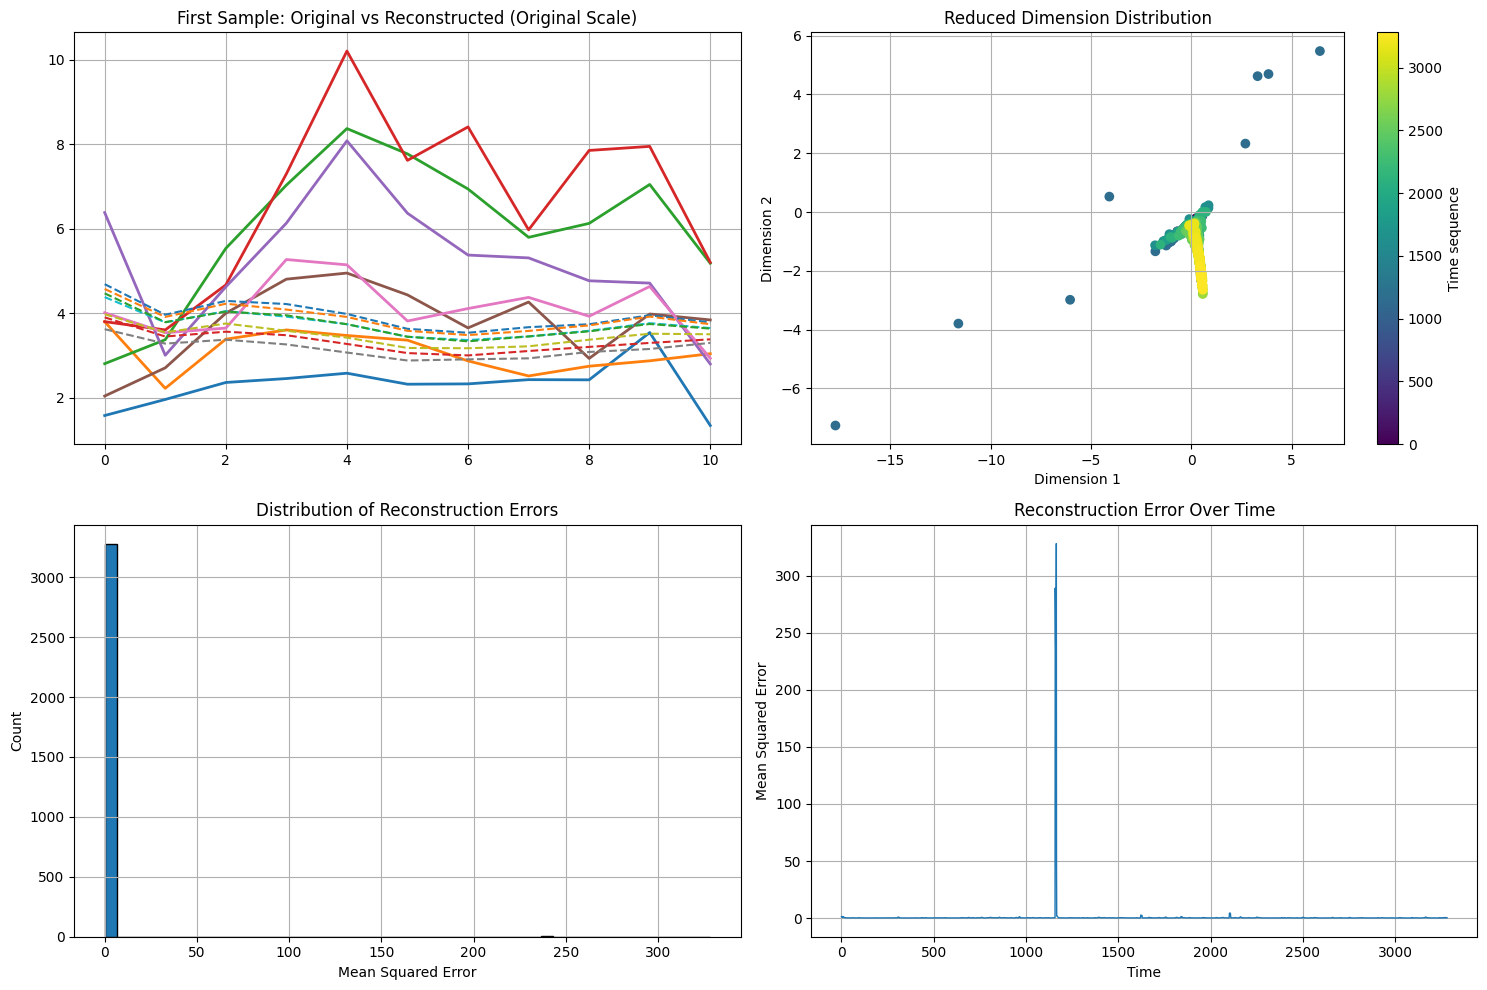


=== Autoencoder Performance Metrics (Original Scale) ===
재구성 오차 (MSE): 3.1772
재구성 오차 (RMSE): 1.7825
설명된 분산 비율: 0.2158

=== 연령대별 재구성 오차 (Original Scale) ===
연령대 1: 0.8778
연령대 2: 0.7824
연령대 3: 0.7227
연령대 4: 0.7507
연령대 5: 0.7582
연령대 6: 0.7197
연령대 7: 0.7467
연령대 8: 0.8071
연령대 9: 0.8085
연령대 10: 0.8324
연령대 11: 0.8934
| 1         | 0.2158    | 28.97     | 0.4759    | 159.8     | 3.796     | 0.01569   | 10.46     | 7.0       |
Epoch 1/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 5.5865 - val_loss: 3.8846
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0621 - val_loss: 0.8304
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1154 - val_loss: 0.7774
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7708 - val_loss: 0.7689
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5175 - val_loss: 0.7651
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2712 - val_loss: 0.7657
Epoch 7/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9694 -

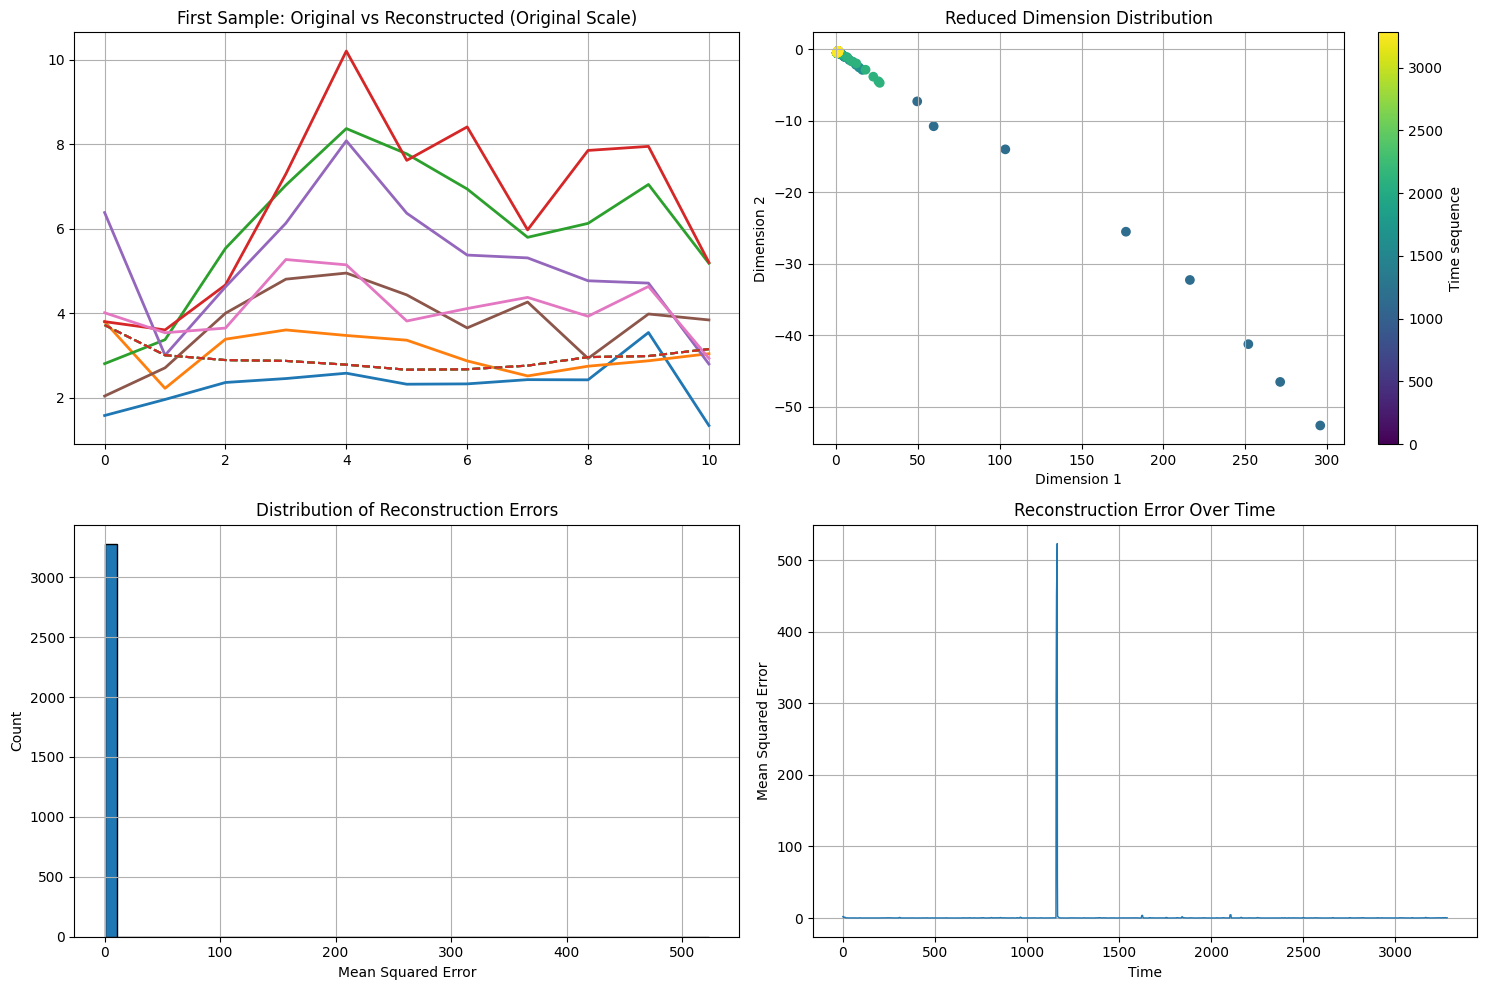


=== Autoencoder Performance Metrics (Original Scale) ===
재구성 오차 (MSE): 4.7432
재구성 오차 (RMSE): 2.1779
설명된 분산 비율: -0.1773

=== 연령대별 재구성 오차 (Original Scale) ===
연령대 1: 1.2869
연령대 2: 1.5938
연령대 3: 0.9763
연령대 4: 1.2599
연령대 5: 1.1024
연령대 6: 1.0119
연령대 7: 1.1838
연령대 8: 1.0519
연령대 9: 1.5695
연령대 10: 0.9403
연령대 11: 1.2296
| 2         | -0.1773   | 56.51     | 0.3045    | 156.2     | 2.062     | 0.09699   | 34.14     | 7.0       |
Epoch 1/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 2.8392 - val_loss: 8.3019
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2303 - val_loss: 1.1437
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9482 - val_loss: 0.8010
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1301 - val_loss: 0.7944
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4619 - val_loss: 1.4651
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8753 - val_loss: 0.7788
Epoch 7/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5896

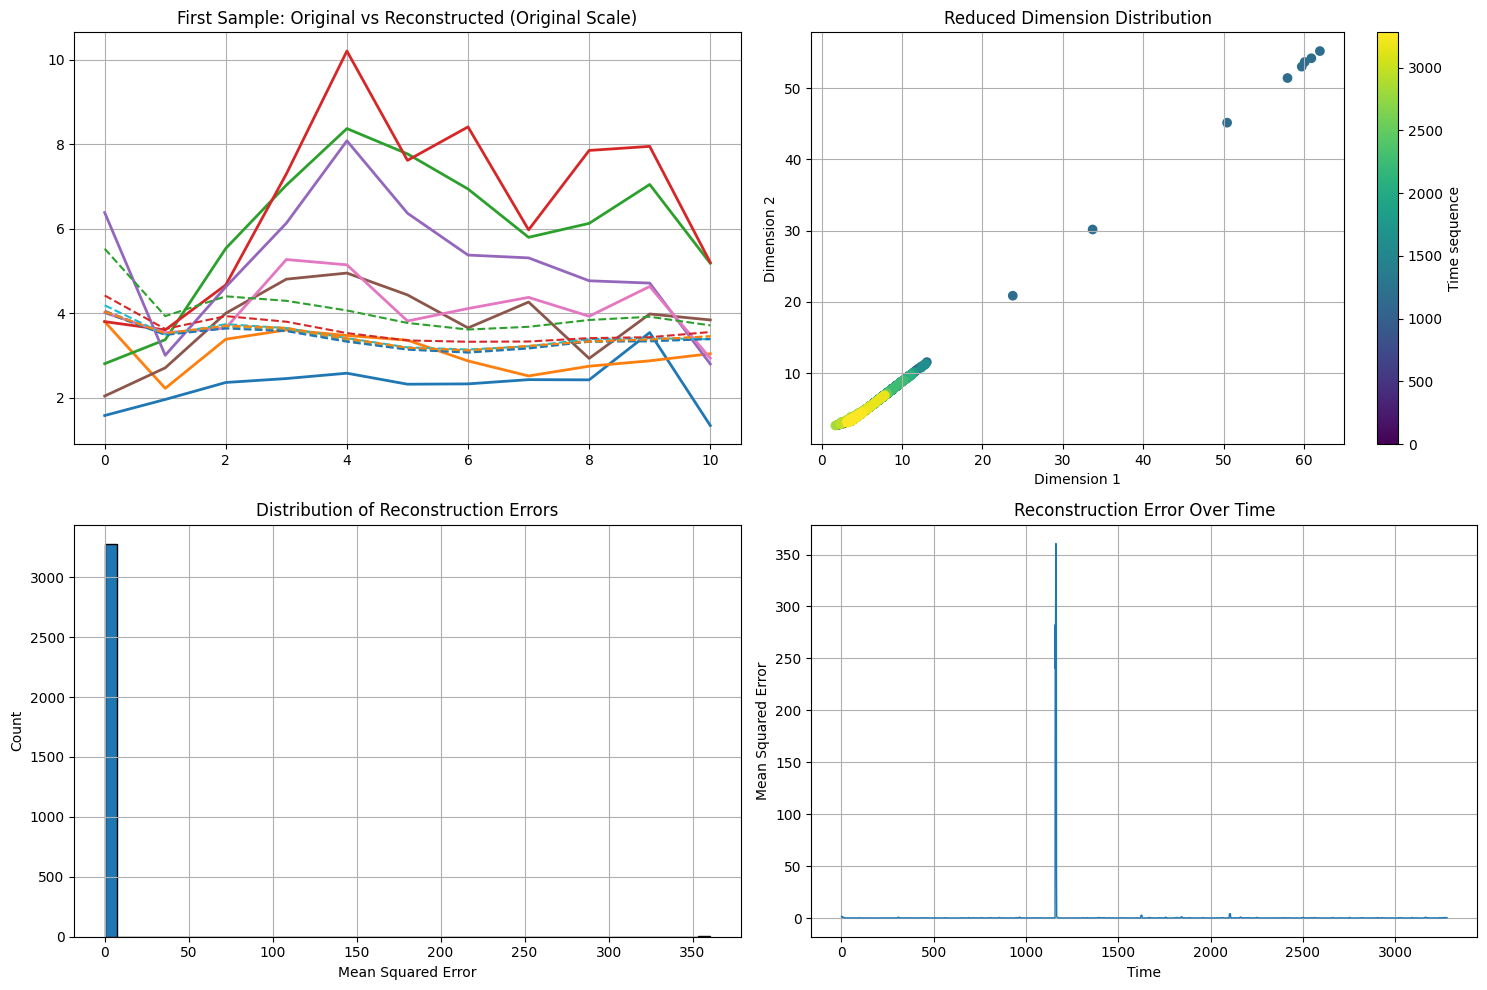


=== Autoencoder Performance Metrics (Original Scale) ===
재구성 오차 (MSE): 3.5872
재구성 오차 (RMSE): 1.8940
설명된 분산 비율: 0.1095

=== 연령대별 재구성 오차 (Original Scale) ===
연령대 1: 0.9707
연령대 2: 0.8925
연령대 3: 0.8400
연령대 4: 0.8595
연령대 5: 0.8837
연령대 6: 0.8604
연령대 7: 0.8605
연령대 8: 0.9002
연령대 9: 0.8989
연령대 10: 0.9299
연령대 11: 0.9466
| 3         | 0.1095    | 18.18     | 0.09987   | 95.64     | 3.574     | 0.04325   | 15.19     | 7.0       |
Epoch 1/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 4.3343 - val_loss: 1.3241
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8599 - val_loss: 7.4991
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6543 - val_loss: 0.8953
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6671 - val_loss: 10.9796
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9830 - val_loss: 3.6157
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8158 - val_loss: 1.4750
Epoch 7/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3392 

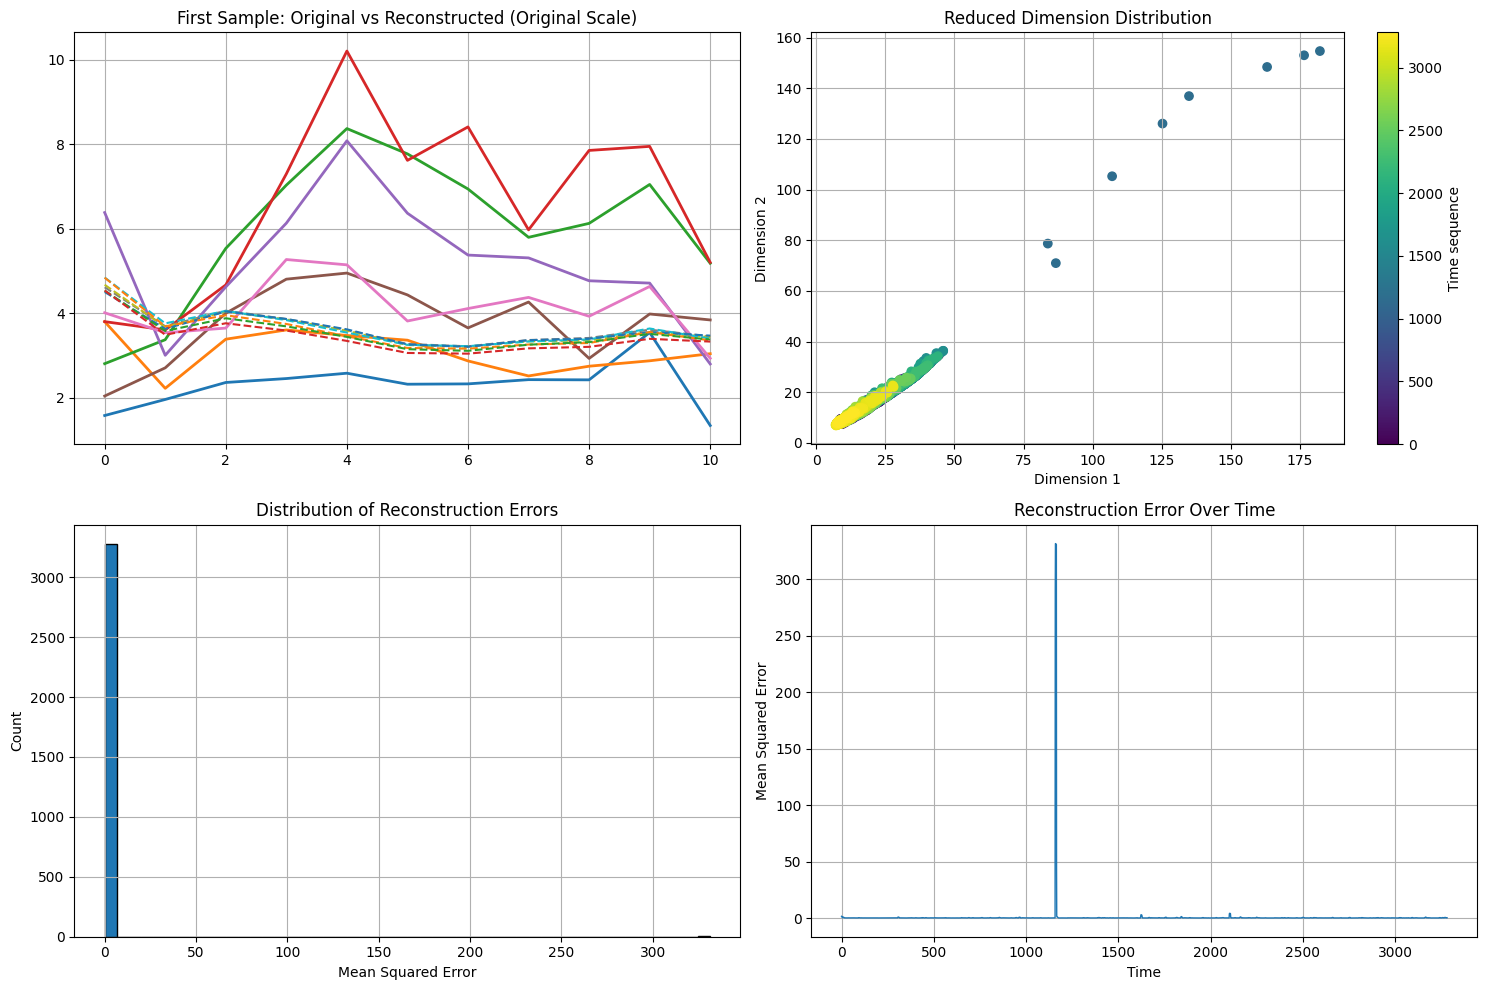


=== Autoencoder Performance Metrics (Original Scale) ===
재구성 오차 (MSE): 3.6432
재구성 오차 (RMSE): 1.9087
설명된 분산 비율: 0.0972

=== 연령대별 재구성 오차 (Original Scale) ===
연령대 1: 1.0088
연령대 2: 0.9032
연령대 3: 0.8544
연령대 4: 0.8626
연령대 5: 0.8847
연령대 6: 0.8686
연령대 7: 0.8655
연령대 8: 0.9033
연령대 9: 0.8912
연령대 10: 0.9303
연령대 11: 0.9459
| 4         | 0.09724   | 15.81     | 0.1532    | 105.0     | 3.368     | 0.07854   | 11.99     | 7.0       |
Epoch 1/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.6113 - val_loss: 0.7228
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7802 - val_loss: 0.9052
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8704 - val_loss: 7.5320
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1870 - val_loss: 0.8784
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9148 - val_loss: 0.6946
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0449 - val_loss: 0.8646
Epoch 7/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0476 -

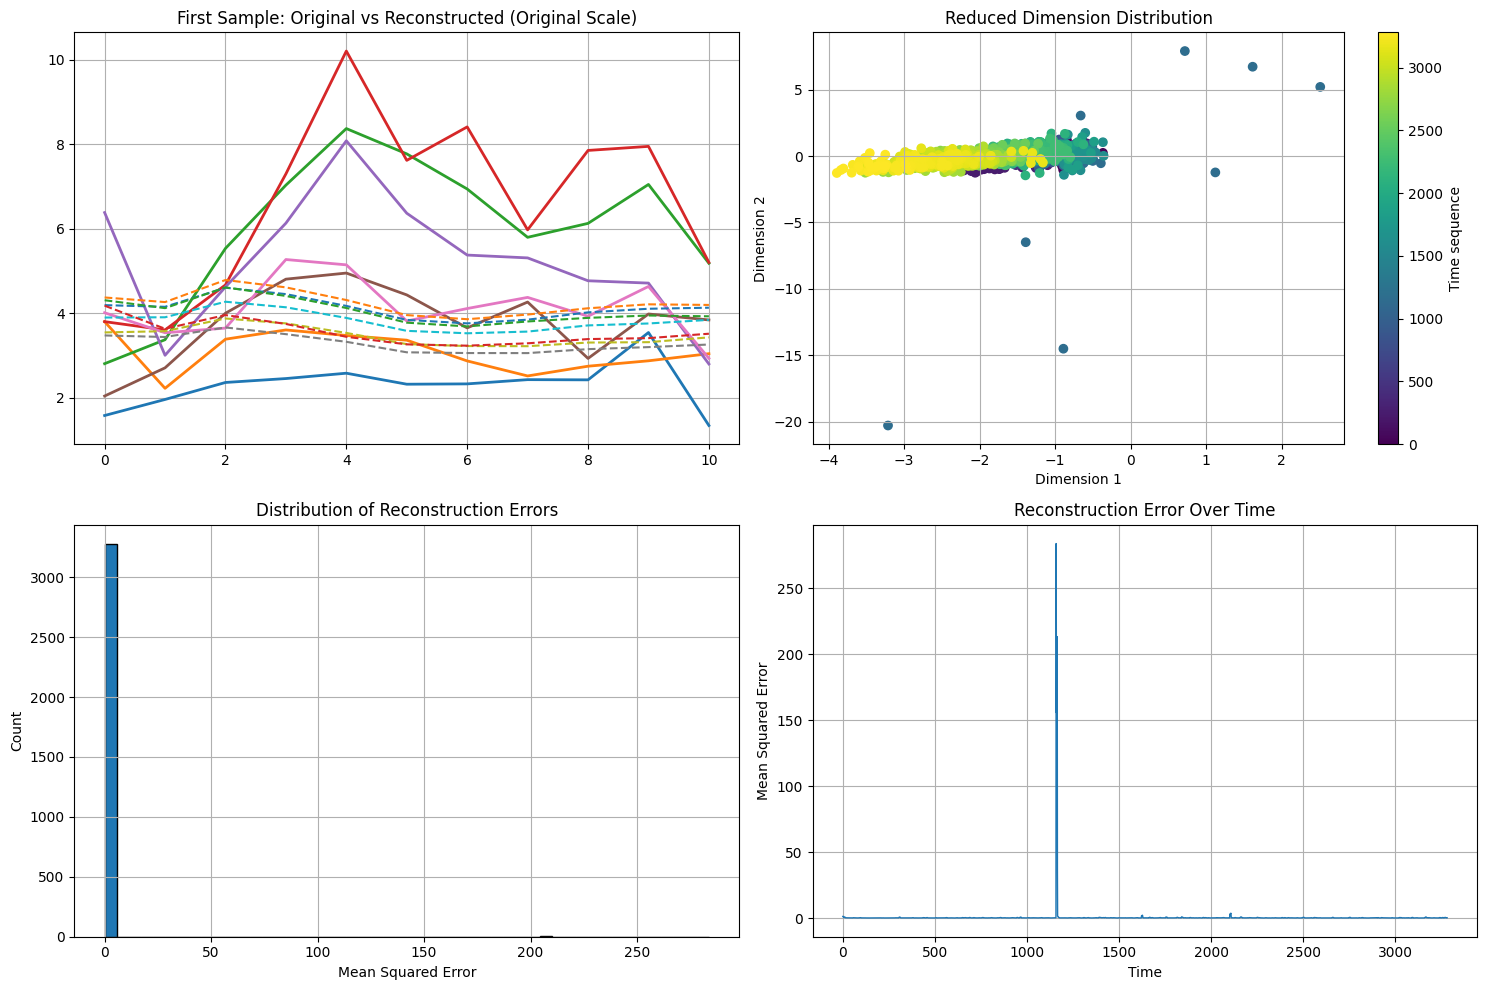


=== Autoencoder Performance Metrics (Original Scale) ===
재구성 오차 (MSE): 2.6574
재구성 오차 (RMSE): 1.6302
설명된 분산 비율: 0.3431

=== 연령대별 재구성 오차 (Original Scale) ===
연령대 1: 0.7923
연령대 2: 0.6345
연령대 3: 0.5614
연령대 4: 0.6010
연령대 5: 0.6124
연령대 6: 0.5683
연령대 7: 0.6011
연령대 8: 0.6547
연령대 9: 0.6456
연령대 10: 0.6803
연령대 11: 0.7663
| 5         | 0.3431    | 41.18     | 0.03276   | 141.1     | 2.512     | 0.006599  | 38.21     | 7.0       |
Epoch 1/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.2833 - val_loss: 1.8608
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5172 - val_loss: 0.8386
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4457 - val_loss: 0.7221
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9422 - val_loss: 0.7119
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0160 - val_loss: 1.5322
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7516 - val_loss: 1.2131
Epoch 7/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9883 -

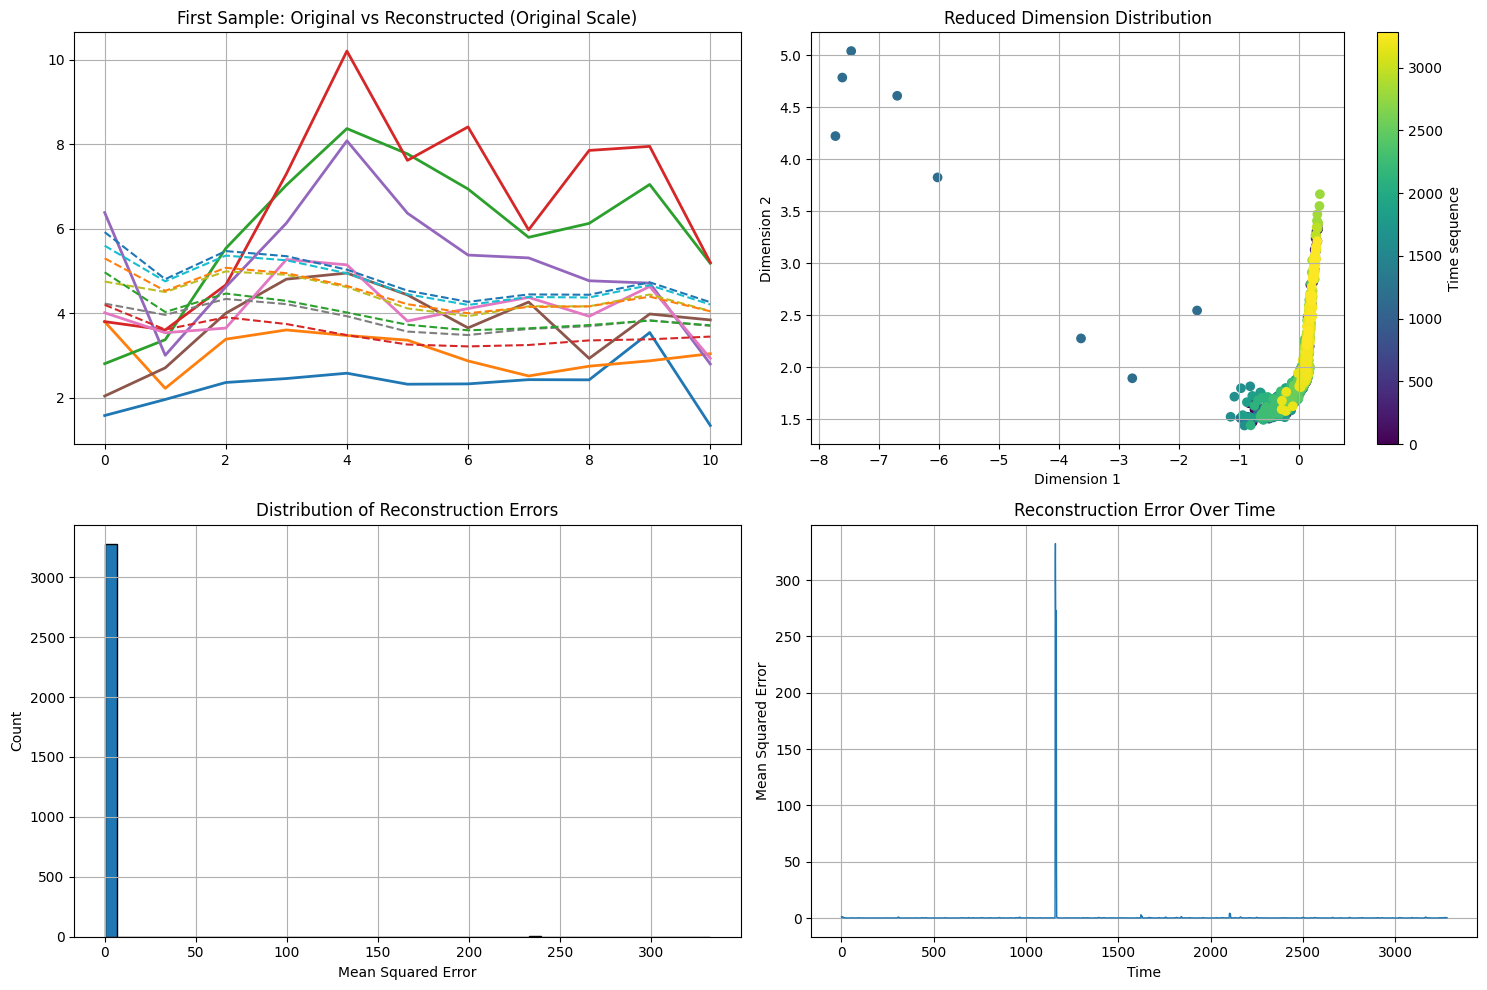


=== Autoencoder Performance Metrics (Original Scale) ===
재구성 오차 (MSE): 3.1537
재구성 오차 (RMSE): 1.7759
설명된 분산 비율: 0.2184

=== 연령대별 재구성 오차 (Original Scale) ===
연령대 1: 0.8952
연령대 2: 0.7716
연령대 3: 0.6971
연령대 4: 0.7292
연령대 5: 0.7570
연령대 6: 0.7192
연령대 7: 0.7318
연령대 8: 0.7856
연령대 9: 0.7771
연령대 10: 0.8192
연령대 11: 0.8745
| 6         | 0.2184    | 41.03     | 0.3791    | 134.8     | 2.035     | 0.02119   | 38.7      | 7.0       |
Epoch 1/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 4.2645 - val_loss: 73.4699
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3755 - val_loss: 3.0032
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5394 - val_loss: 1.1554
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6735 - val_loss: 0.9661
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0944 - val_loss: 0.9210
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1423 - val_loss: 0.9198
Epoch 7/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4416

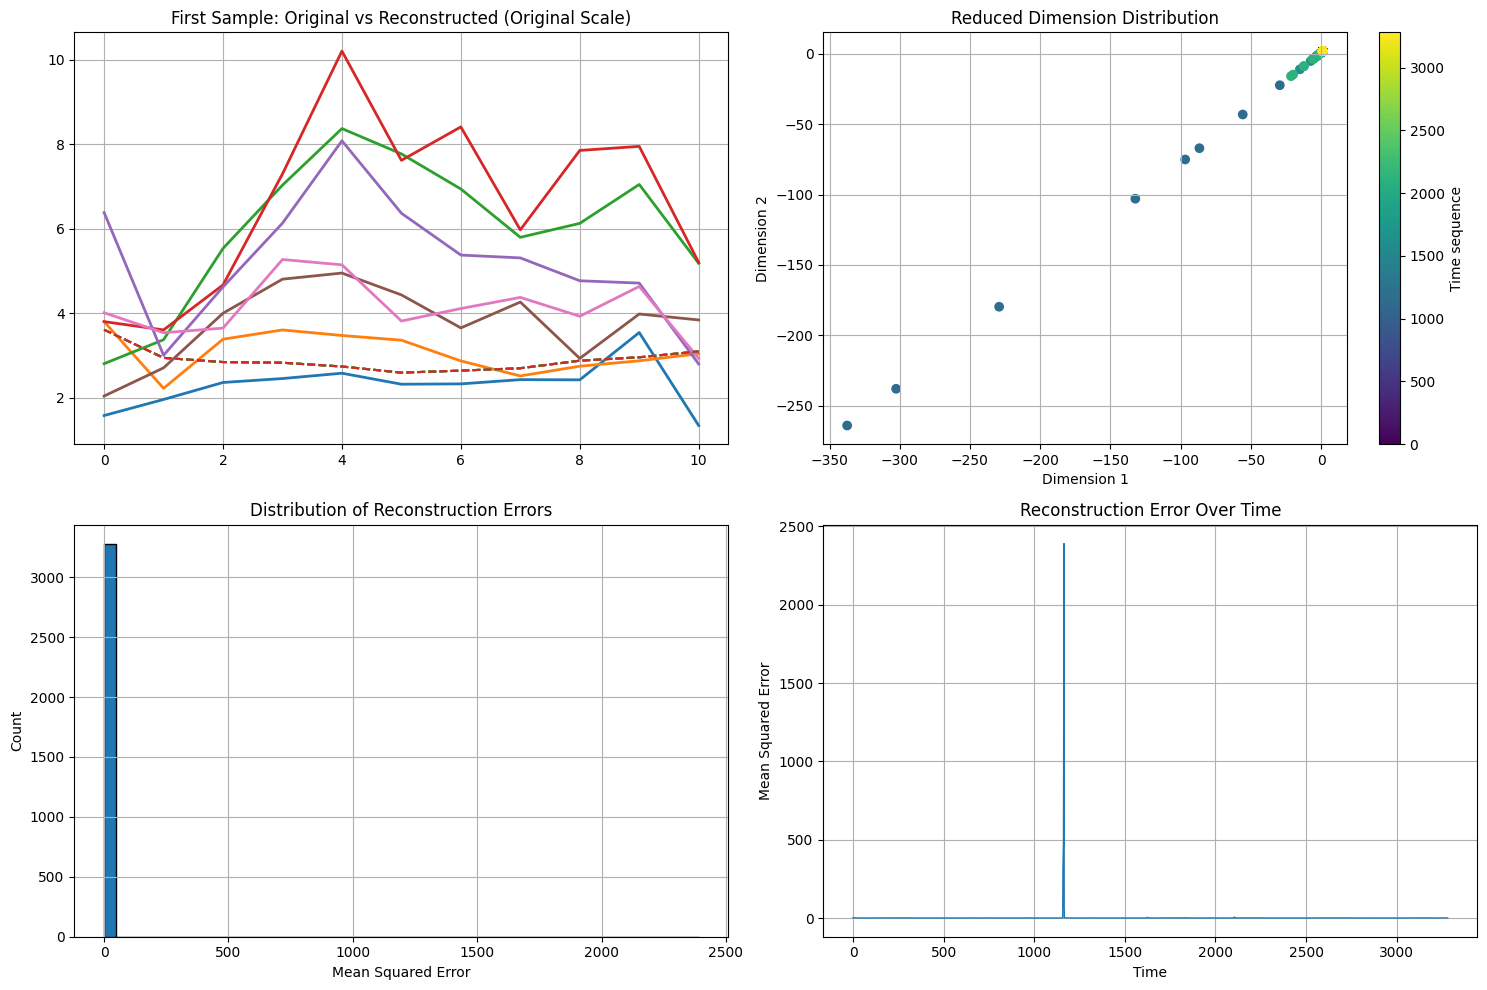


=== Autoencoder Performance Metrics (Original Scale) ===
재구성 오차 (MSE): 10.6815
재구성 오차 (RMSE): 3.2683
설명된 분산 비율: -1.6504

=== 연령대별 재구성 오차 (Original Scale) ===
연령대 1: 3.1629
연령대 2: 3.3644
연령대 3: 1.5659
연령대 4: 0.8577
연령대 5: 5.4993
연령대 6: 1.2433
연령대 7: 0.8996
연령대 8: 3.1980
연령대 9: 1.1396
연령대 10: 4.1265
연령대 11: 0.9946
| 7         | -1.65     | 33.74     | 0.2146    | 144.0     | 3.096     | 0.09582   | 36.55     | 7.0       |
Epoch 1/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 6.7027 - val_loss: 2.0650
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5801 - val_loss: 0.7903
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.0222 - val_loss: 0.7635
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.8839 - val_loss: 0.7604
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6138 - val_loss: 0.7606
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3191 - val_loss: 0.7604
Epoch 7/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6011

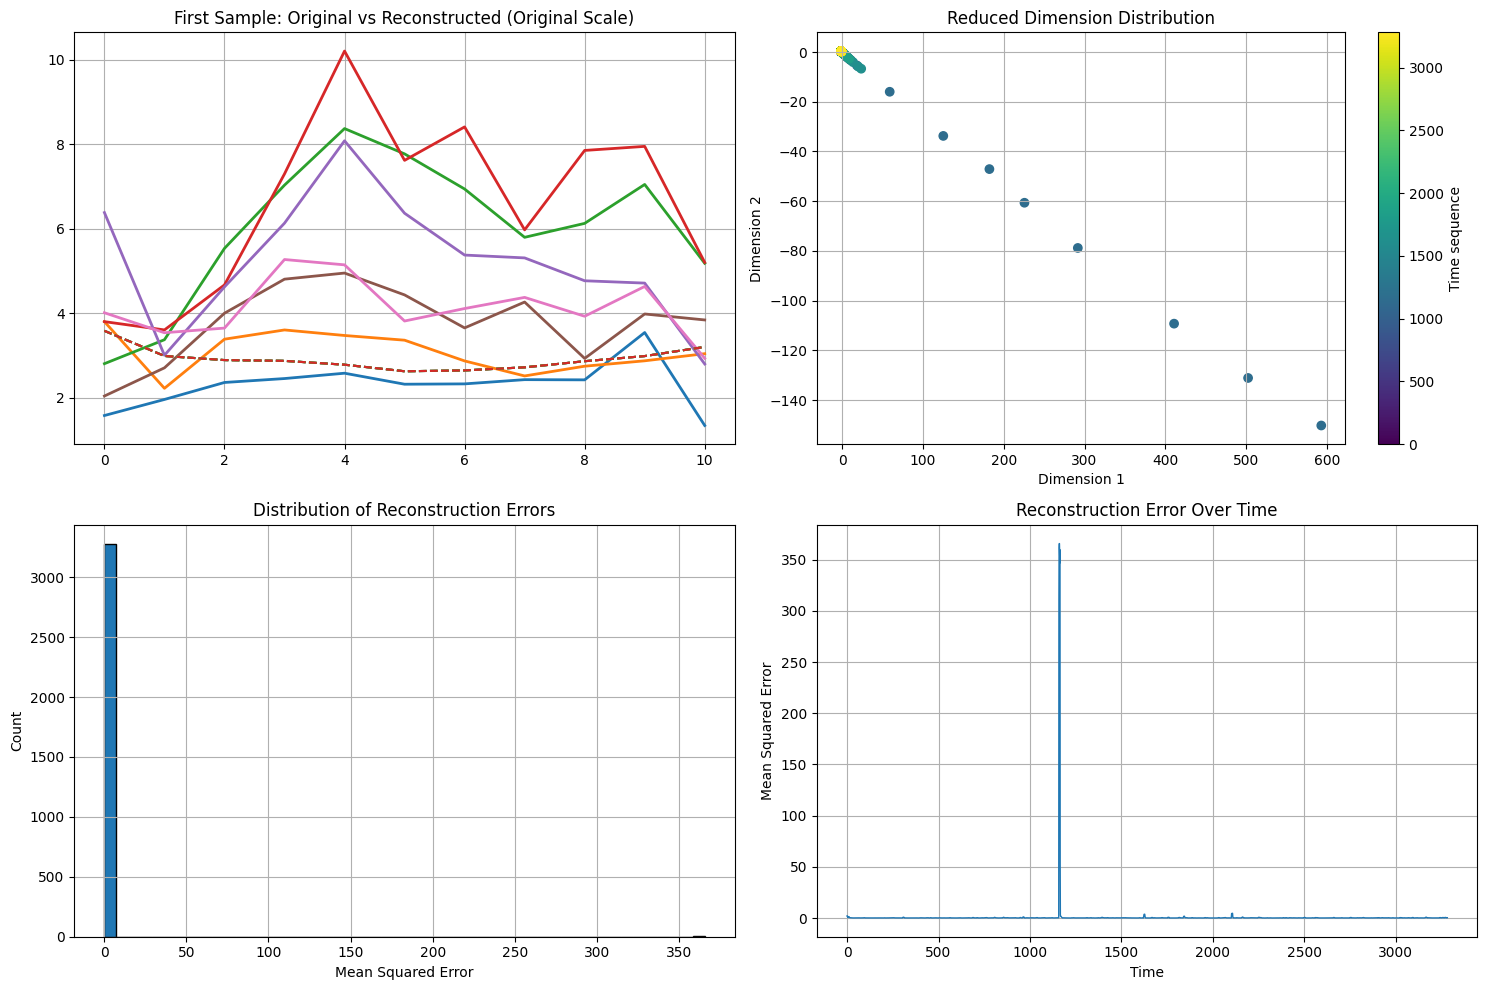


=== Autoencoder Performance Metrics (Original Scale) ===
재구성 오차 (MSE): 4.1306
재구성 오차 (RMSE): 2.0324
설명된 분산 비율: -0.0248

=== 연령대별 재구성 오차 (Original Scale) ===
연령대 1: 1.1486
연령대 2: 0.8697
연령대 3: 0.8704
연령대 4: 1.1783
연령대 5: 1.1488
연령대 6: 0.9091
연령대 7: 0.8714
연령대 8: 0.8812
연령대 9: 0.8640
연령대 10: 1.1881
연령대 11: 1.0150
| 8         | -0.02481  | 42.18     | 0.306     | 142.9     | 3.634     | 0.09559   | 36.44     | 7.0       |
Epoch 1/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.3594 - val_loss: 3.0265
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3519 - val_loss: 0.7155
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0259 - val_loss: 0.7255
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7971 - val_loss: 1.5120
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5265 - val_loss: 2.2411
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0973 - val_loss: 0.8689
Epoch 7/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6827 

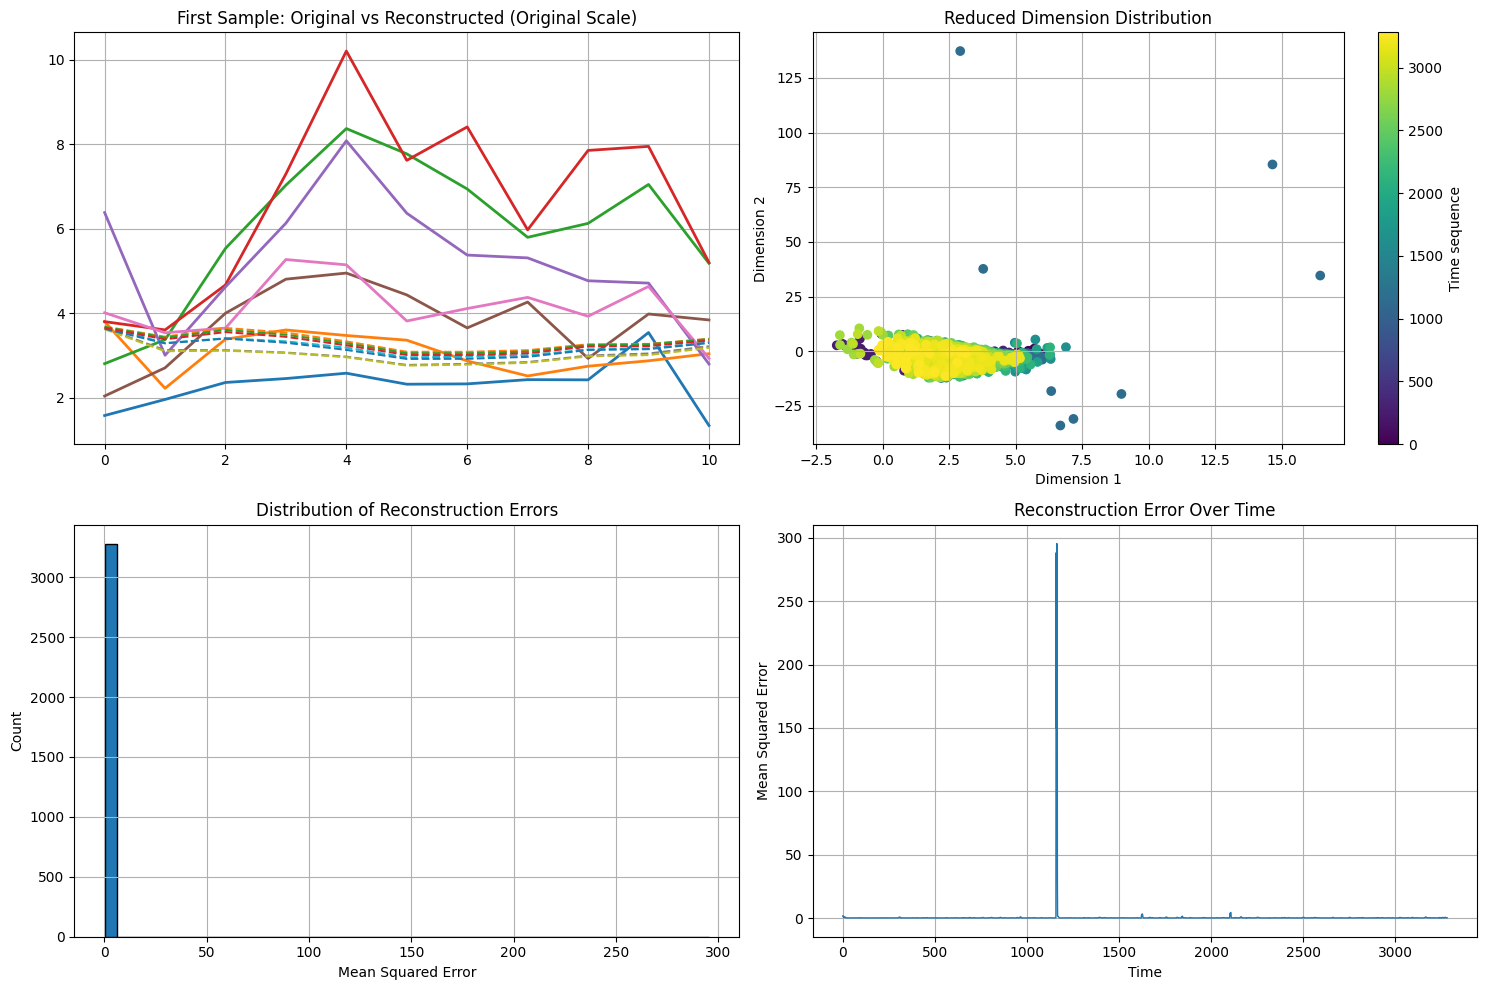


=== Autoencoder Performance Metrics (Original Scale) ===
재구성 오차 (MSE): 2.8907
재구성 오차 (RMSE): 1.7002
설명된 분산 비율: 0.2856

=== 연령대별 재구성 오차 (Original Scale) ===
연령대 1: 0.8333
연령대 2: 0.6927
연령대 3: 0.6518
연령대 4: 0.6737
연령대 5: 0.6779
연령대 6: 0.6425
연령대 7: 0.6661
연령대 8: 0.7068
연령대 9: 0.7124
연령대 10: 0.7338
연령대 11: 0.8138
| 9         | 0.2856    | 44.24     | 0.05967   | 138.7     | 3.859     | 0.02489   | 39.91     | 7.0       |
Epoch 1/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.2446 - val_loss: 0.7579
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7904 - val_loss: 0.7592
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5994 - val_loss: 0.7495
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6551 - val_loss: 0.7622
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9376 - val_loss: 0.7600
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7391 - val_loss: 0.7596
Epoch 7/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0209 -

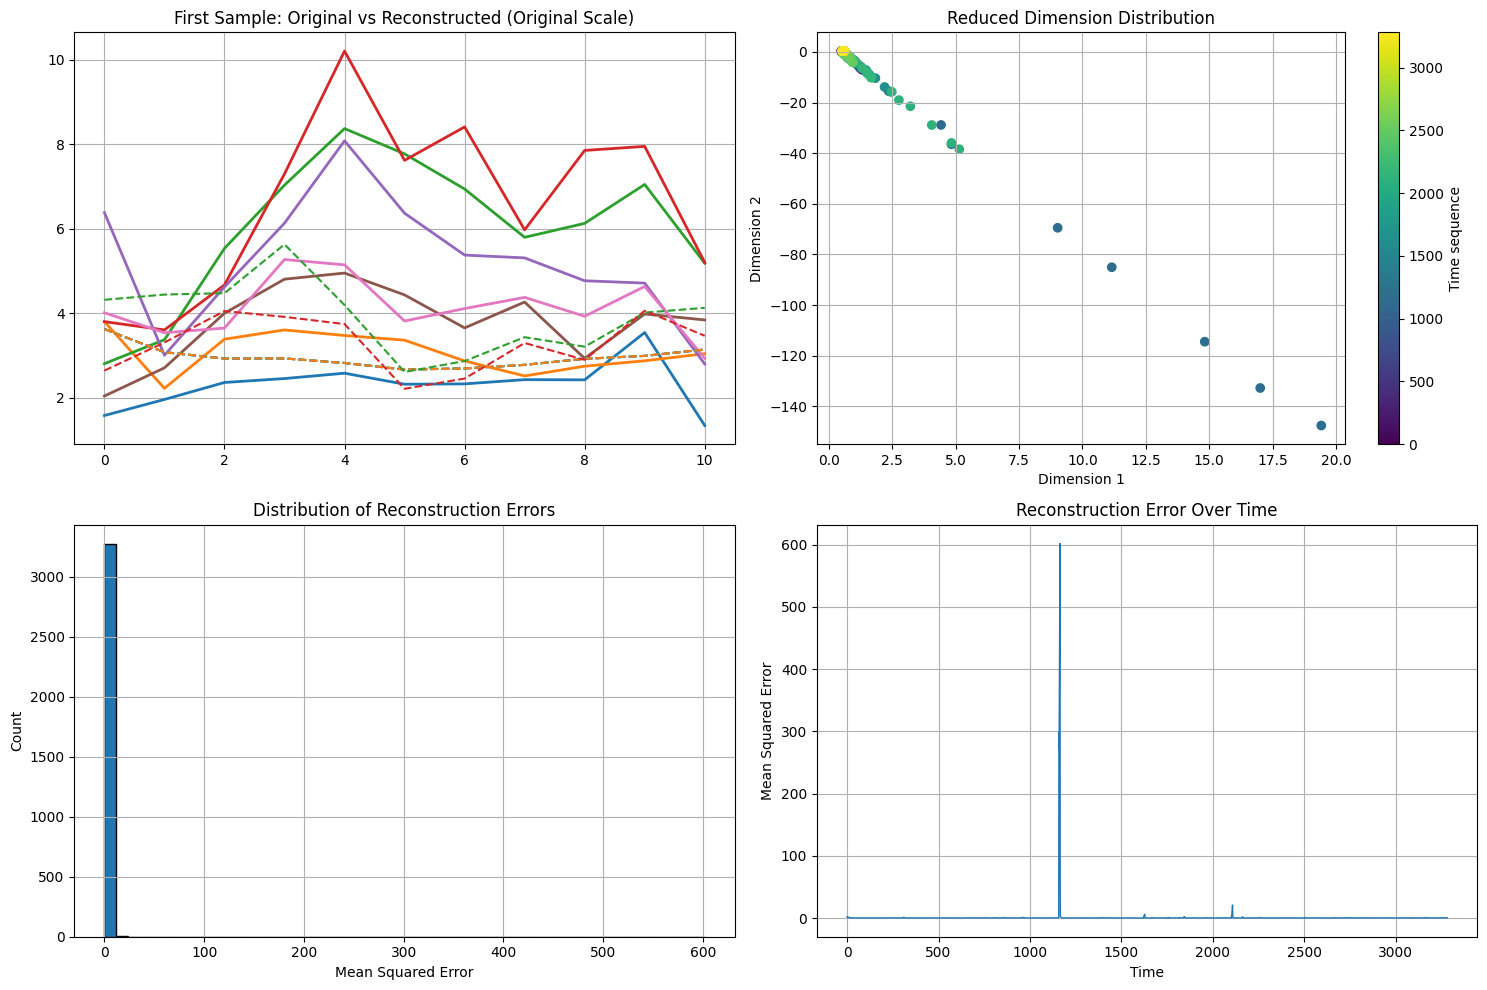


=== Autoencoder Performance Metrics (Original Scale) ===
재구성 오차 (MSE): 4.6236
재구성 오차 (RMSE): 2.1502
설명된 분산 비율: -0.1478

=== 연령대별 재구성 오차 (Original Scale) ===
연령대 1: 1.0494
연령대 2: 1.1884
연령대 3: 1.2605
연령대 4: 1.6549
연령대 5: 1.1785
연령대 6: 1.0839
연령대 7: 1.0183
연령대 8: 1.0508
연령대 9: 0.9949
연령대 10: 1.2002
연령대 11: 1.1760
| 10        | -0.1478   | 46.62     | 0.3121    | 135.0     | 3.125     | 0.06691   | 32.4      | 7.0       |
Epoch 1/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.9039 - val_loss: 3.6326
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8384 - val_loss: 0.8786
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9621 - val_loss: 0.8083
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6887 - val_loss: 0.7699
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5887 - val_loss: 0.7653
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3640 - val_loss: 0.7606
Epoch 7/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3415 

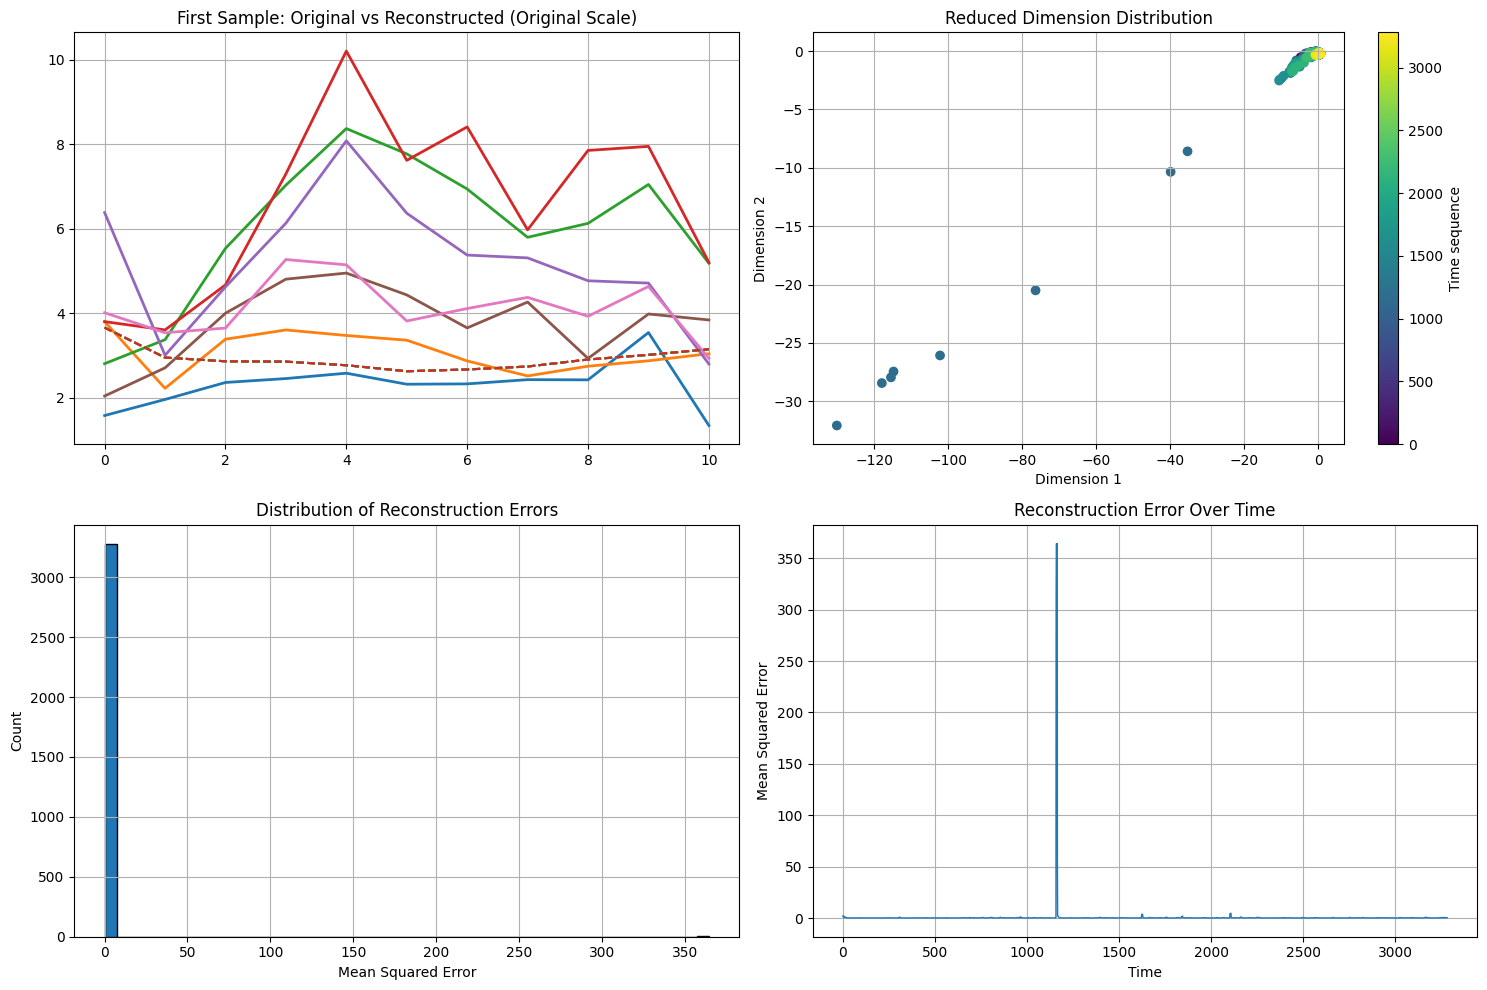


=== Autoencoder Performance Metrics (Original Scale) ===
재구성 오차 (MSE): 3.9571
재구성 오차 (RMSE): 1.9892
설명된 분산 비율: 0.0182

=== 연령대별 재구성 오차 (Original Scale) ===
연령대 1: 1.0218
연령대 2: 1.0115
연령대 3: 0.9876
연령대 4: 0.9836
연령대 5: 0.9774
연령대 6: 0.9840
연령대 7: 1.0133
연령대 8: 1.0073
연령대 9: 0.9801
연령대 10: 1.0095
연령대 11: 1.0085
| 11        | 0.01821   | 24.57     | 0.1887    | 164.7     | 4.9       | 0.07452   | 8.943     | 7.0       |
Epoch 1/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.4647 - val_loss: 0.7710
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2386 - val_loss: 0.7718
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8513 - val_loss: 0.7624
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8198 - val_loss: 0.7610
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5015 - val_loss: 0.7615
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2276 - val_loss: 0.7601
Epoch 7/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7407 -

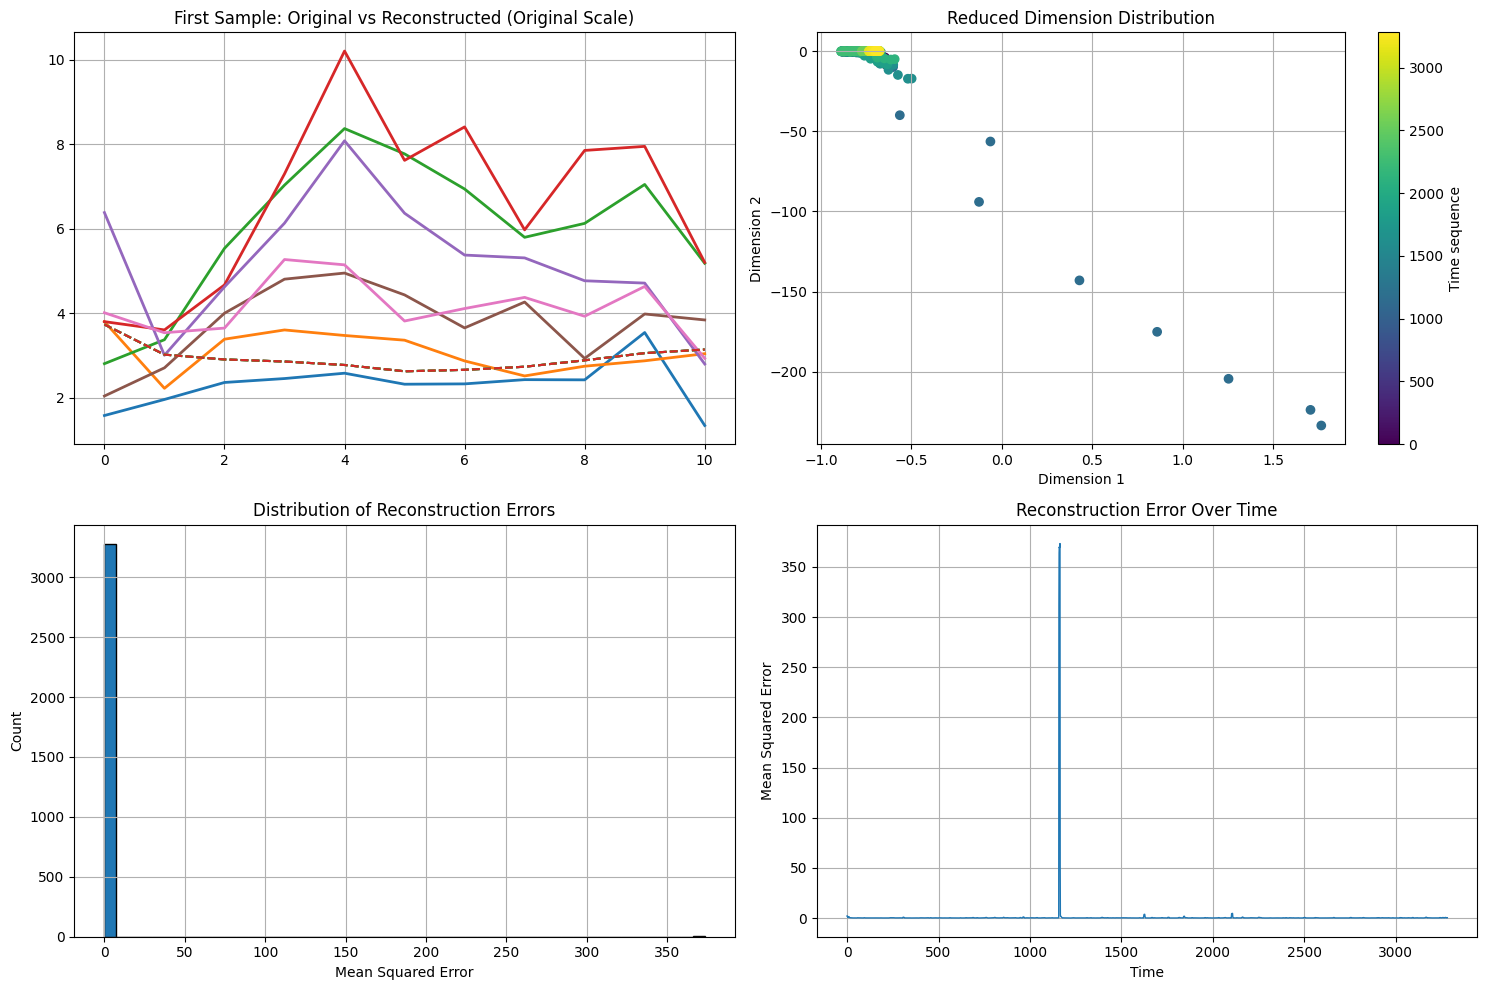


=== Autoencoder Performance Metrics (Original Scale) ===
재구성 오차 (MSE): 4.0239
재구성 오차 (RMSE): 2.0060
설명된 분산 비율: 0.0013

=== 연령대별 재구성 오차 (Original Scale) ===
연령대 1: 1.0491
연령대 2: 0.9744
연령대 3: 1.0435
연령대 4: 0.9722
연령대 5: 0.9732
연령대 6: 1.0474
연령대 7: 1.0555
연령대 8: 0.9761
연령대 9: 0.9874
연령대 10: 1.0352
연령대 11: 1.0416
| 12        | 0.001296  | 29.59     | 0.06327   | 161.6     | 2.244     | 0.06111   | 16.54     | 7.0       |
Epoch 1/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 4.3388 - val_loss: 2.9074
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2203 - val_loss: 1.3335
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6679 - val_loss: 0.9886
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6831 - val_loss: 1.0399
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0946 - val_loss: 0.7478
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7458 - val_loss: 0.7483
Epoch 7/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1389 -

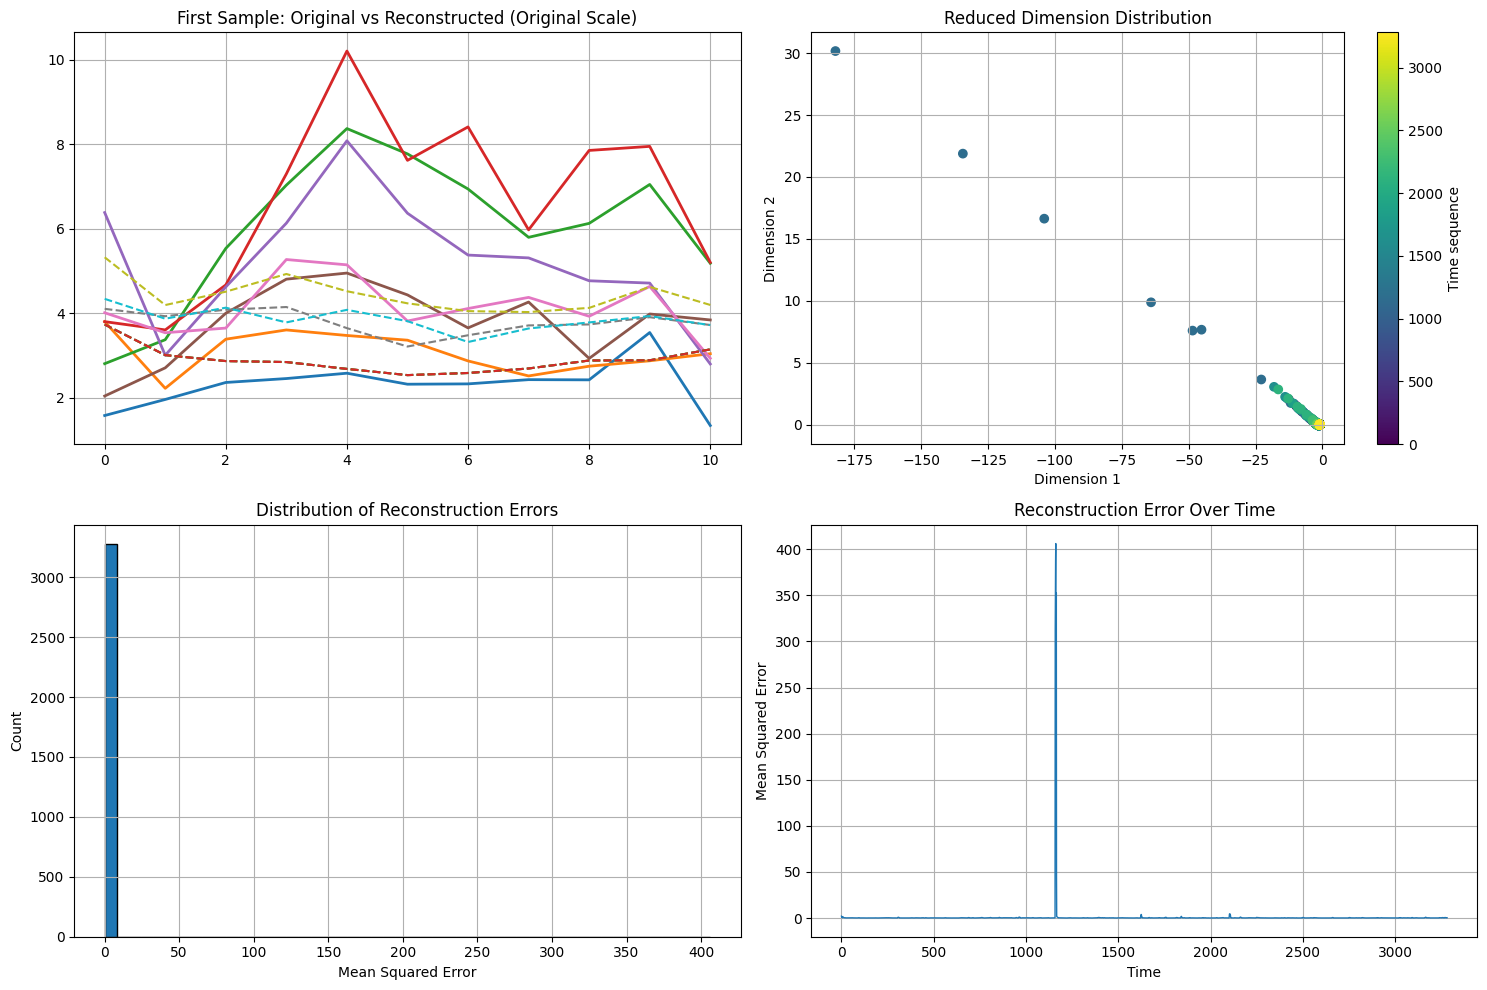


=== Autoencoder Performance Metrics (Original Scale) ===
재구성 오차 (MSE): 3.6196
재구성 오차 (RMSE): 1.9025
설명된 분산 비율: 0.1018

=== 연령대별 재구성 오차 (Original Scale) ===
연령대 1: 0.9590
연령대 2: 0.8779
연령대 3: 0.8698
연령대 4: 0.8807
연령대 5: 0.8985
연령대 6: 0.9021
연령대 7: 0.8938
연령대 8: 0.9219
연령대 9: 0.9310
연령대 10: 0.9165
연령대 11: 0.9515
| 13        | 0.1018    | 35.21     | 0.0267    | 159.0     | 2.224     | 0.08864   | 8.756     | 7.0       |
Epoch 1/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.3828 - val_loss: 18.3885
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7089 - val_loss: 1.1571
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0159 - val_loss: 0.7639
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9831 - val_loss: 0.6972
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9645 - val_loss: 0.7060
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4563 - val_loss: 0.7212
Epoch 7/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0111 

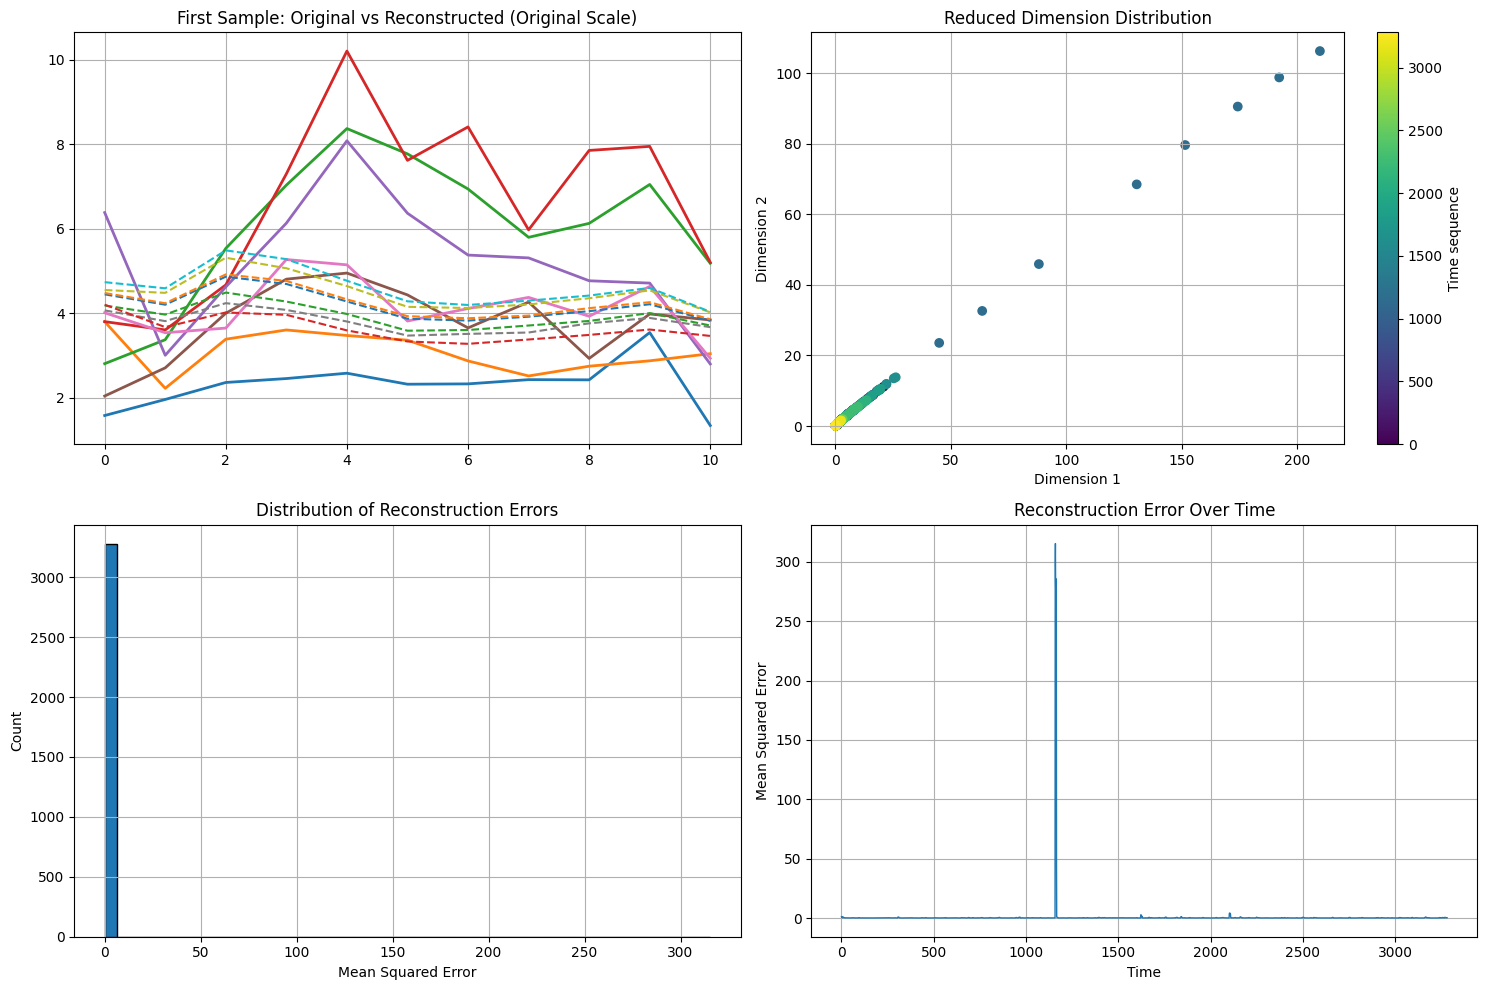


=== Autoencoder Performance Metrics (Original Scale) ===
재구성 오차 (MSE): 3.2200
재구성 오차 (RMSE): 1.7944
설명된 분산 비율: 0.2015

=== 연령대별 재구성 오차 (Original Scale) ===
연령대 1: 0.9295
연령대 2: 0.7870
연령대 3: 0.7209
연령대 4: 0.7410
연령대 5: 0.7629
연령대 6: 0.7246
연령대 7: 0.7352
연령대 8: 0.7888
연령대 9: 0.7777
연령대 10: 0.8236
연령대 11: 0.8866
| 14        | 0.2015    | 28.23     | 0.2993    | 153.8     | 2.762     | 0.04982   | 7.336     | 7.0       |
Epoch 1/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 4.2665 - val_loss: 158.5818
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0491 - val_loss: 2.2694
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2699 - val_loss: 0.9304
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7052 - val_loss: 0.8098
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6600 - val_loss: 0.7887
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5645 - val_loss: 0.7805
Epoch 7/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.011

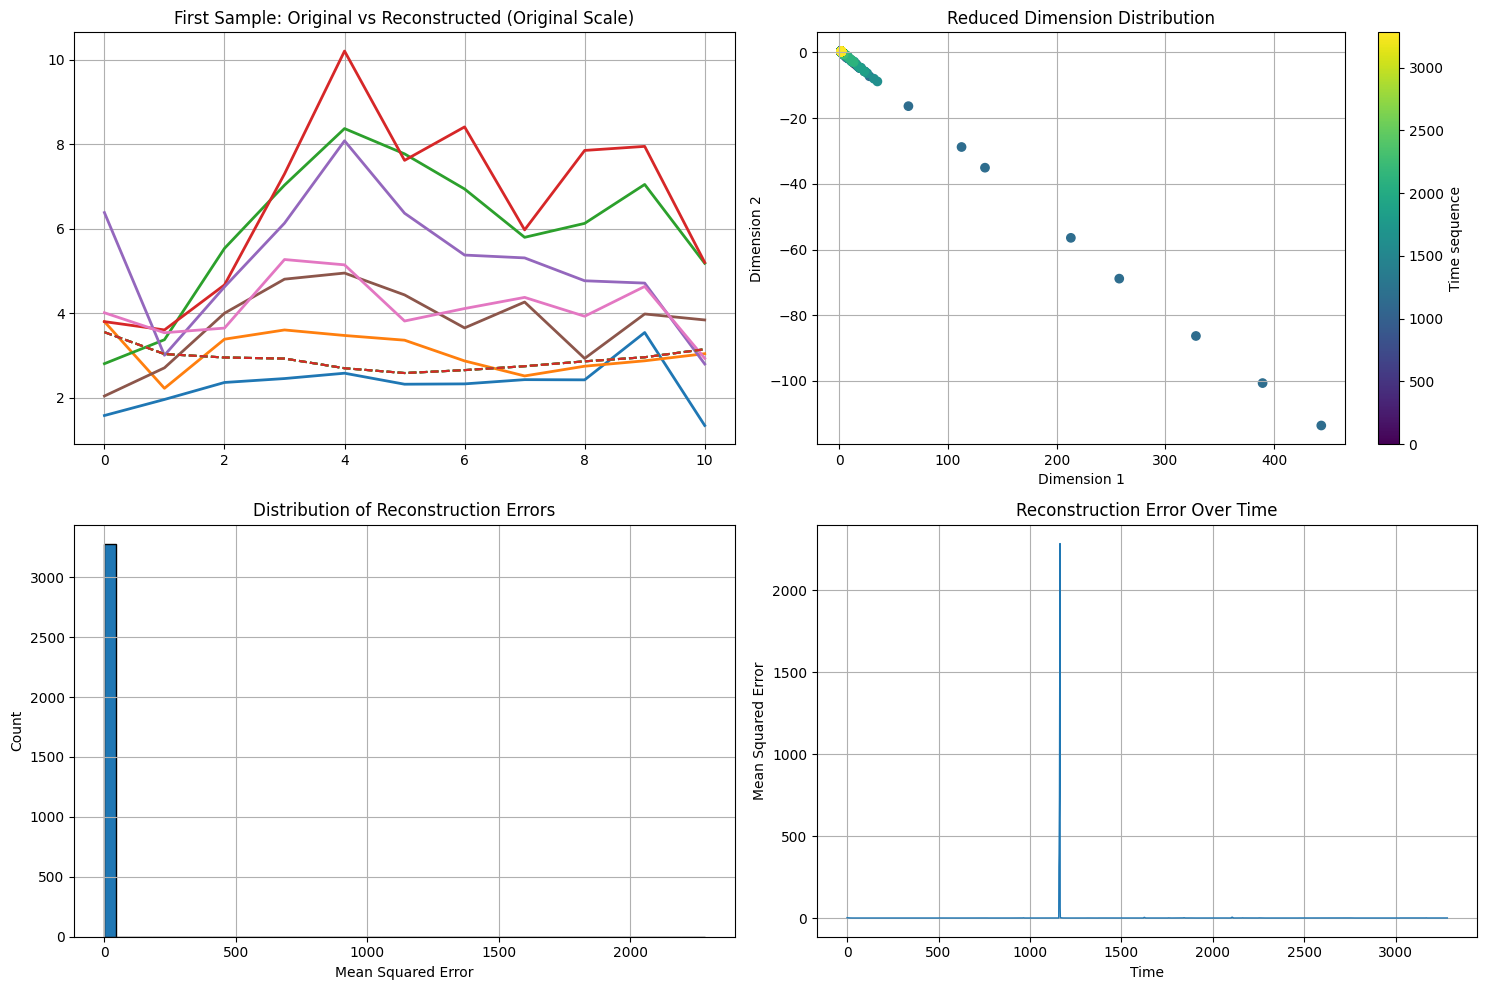


=== Autoencoder Performance Metrics (Original Scale) ===
재구성 오차 (MSE): 9.9757
재구성 오차 (RMSE): 3.1584
설명된 분산 비율: -1.4759

=== 연령대별 재구성 오차 (Original Scale) ===
연령대 1: 2.0671
연령대 2: 2.2331
연령대 3: 3.8554
연령대 4: 3.9828
연령대 5: 3.6278
연령대 6: 1.4204
연령대 7: 2.8828
연령대 8: 3.1749
연령대 9: 0.8376
연령대 10: 1.1418
연령대 11: 1.5533
| 15        | -1.476    | 22.19     | 0.03785   | 154.3     | 4.264     | 0.09811   | 12.42     | 7.0       |
Epoch 1/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.4114 - val_loss: 0.7604
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1902 - val_loss: 0.7593
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1881 - val_loss: 0.7611
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1073 - val_loss: 0.7600
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9428 - val_loss: 0.7594
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6306 - val_loss: 0.7599
Epoch 7/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4223 

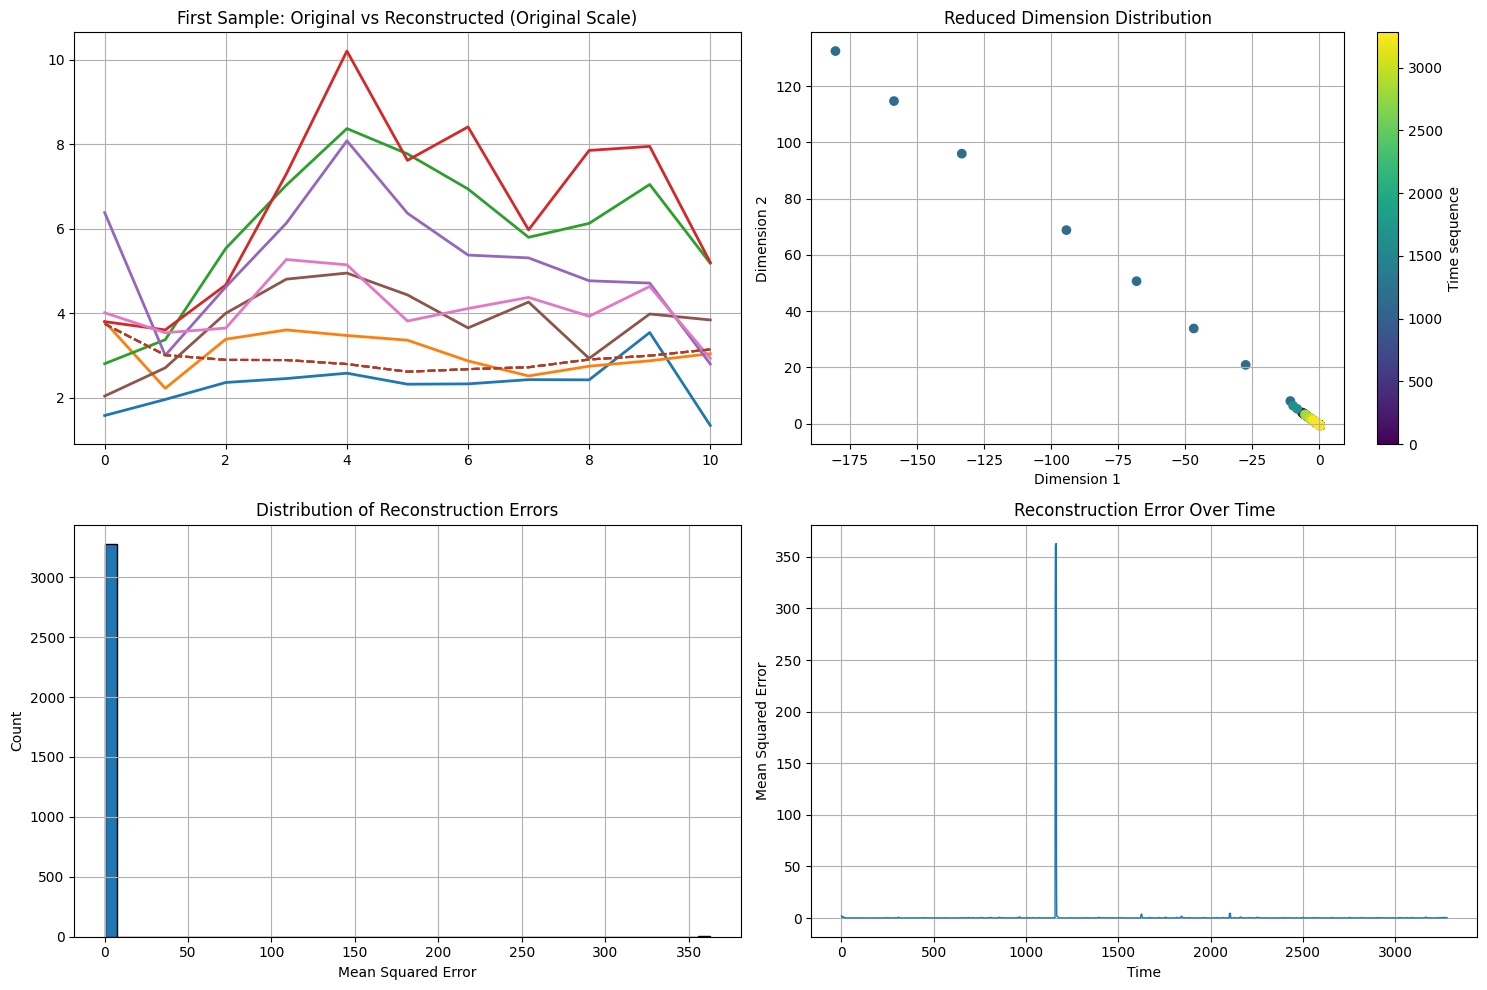


=== Autoencoder Performance Metrics (Original Scale) ===
재구성 오차 (MSE): 3.9512
재구성 오차 (RMSE): 1.9878
설명된 분산 비율: 0.0193

=== 연령대별 재구성 오차 (Original Scale) ===
연령대 1: 1.0017
연령대 2: 1.0020
연령대 3: 1.0017
연령대 4: 1.0000
연령대 5: 0.9993
연령대 6: 0.9979
연령대 7: 0.9979
연령대 8: 1.0005
연령대 9: 0.9999
연령대 10: 1.0009
연령대 11: 1.0013
| 16        | 0.01933   | 32.39     | 0.4697    | 164.7     | 3.244     | 0.05246   | 6.933     | 7.0       |
Epoch 1/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.2722 - val_loss: 7.0772
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7522 - val_loss: 1.1437
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2510 - val_loss: 0.7602
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.3342 - val_loss: 0.7122
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7142 - val_loss: 0.6870
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2479 - val_loss: 0.8084
Epoch 7/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0131 -

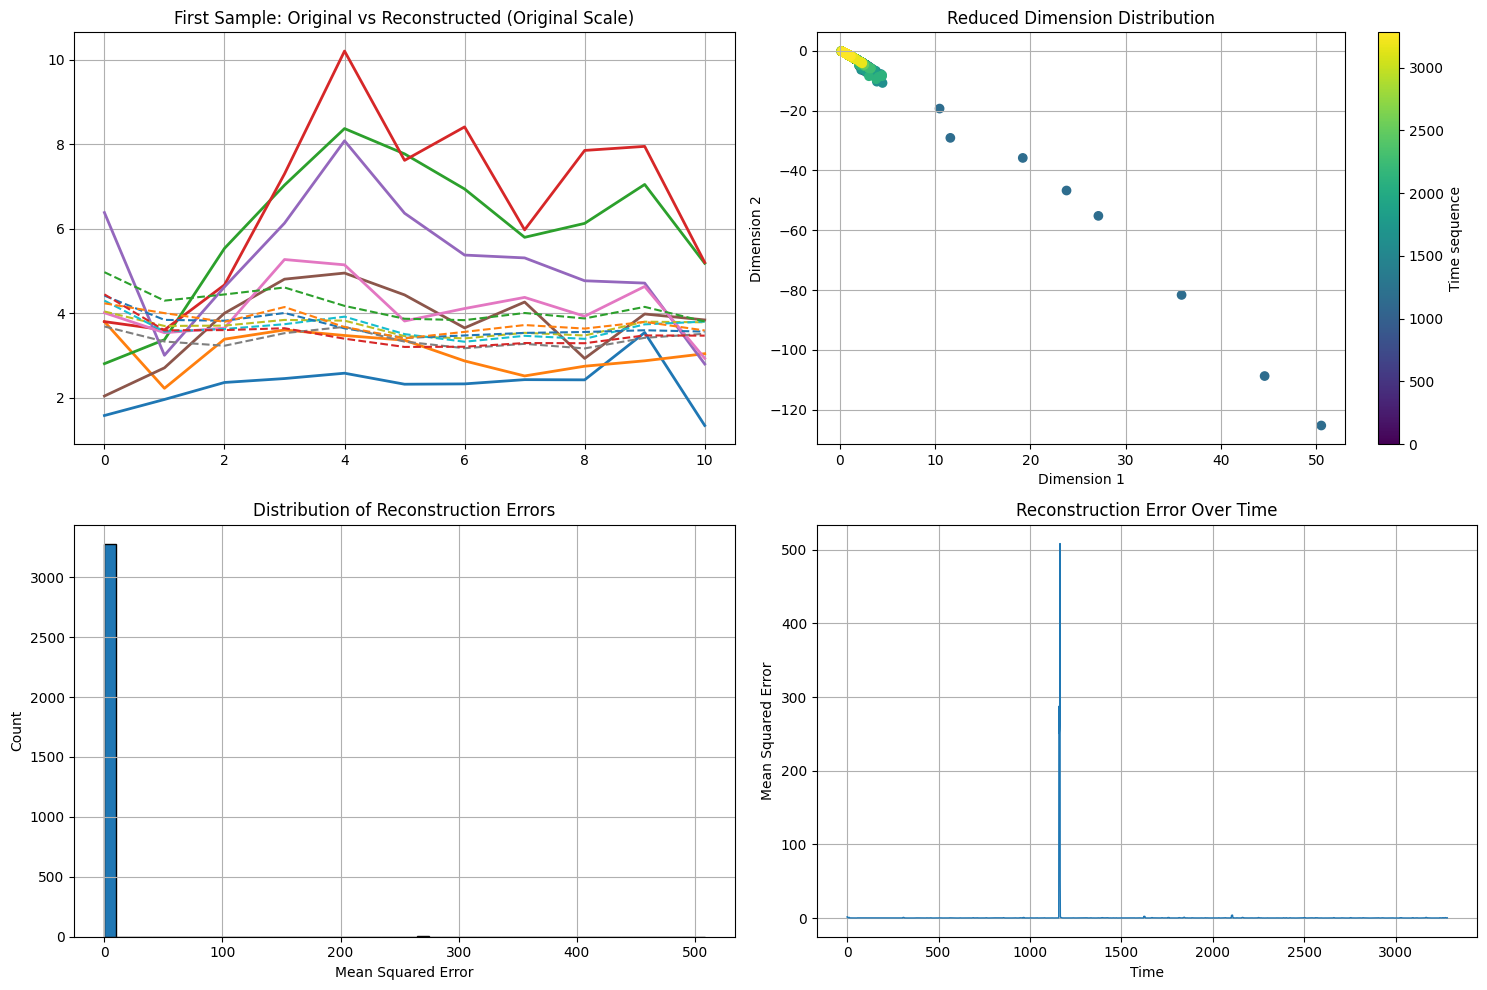


=== Autoencoder Performance Metrics (Original Scale) ===
재구성 오차 (MSE): 3.4919
재구성 오차 (RMSE): 1.8687
설명된 분산 비율: 0.1340

=== 연령대별 재구성 오차 (Original Scale) ===
연령대 1: 0.9339
연령대 2: 0.8687
연령대 3: 0.8203
연령대 4: 0.8601
연령대 5: 0.8493
연령대 6: 0.8335
연령대 7: 0.8674
연령대 8: 0.8973
연령대 9: 0.8837
연령대 10: 0.8899
연령대 11: 0.9251
| 17        | 0.134     | 32.03     | 0.06636   | 150.3     | 4.713     | 0.04905   | 5.039     | 7.0       |
Epoch 1/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.7057 - val_loss: 4.7121
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5752 - val_loss: 0.8615
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1920 - val_loss: 0.9036
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1453 - val_loss: 0.7570
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7489 - val_loss: 0.7766
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7820 - val_loss: 1.9048
Epoch 7/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4835 -

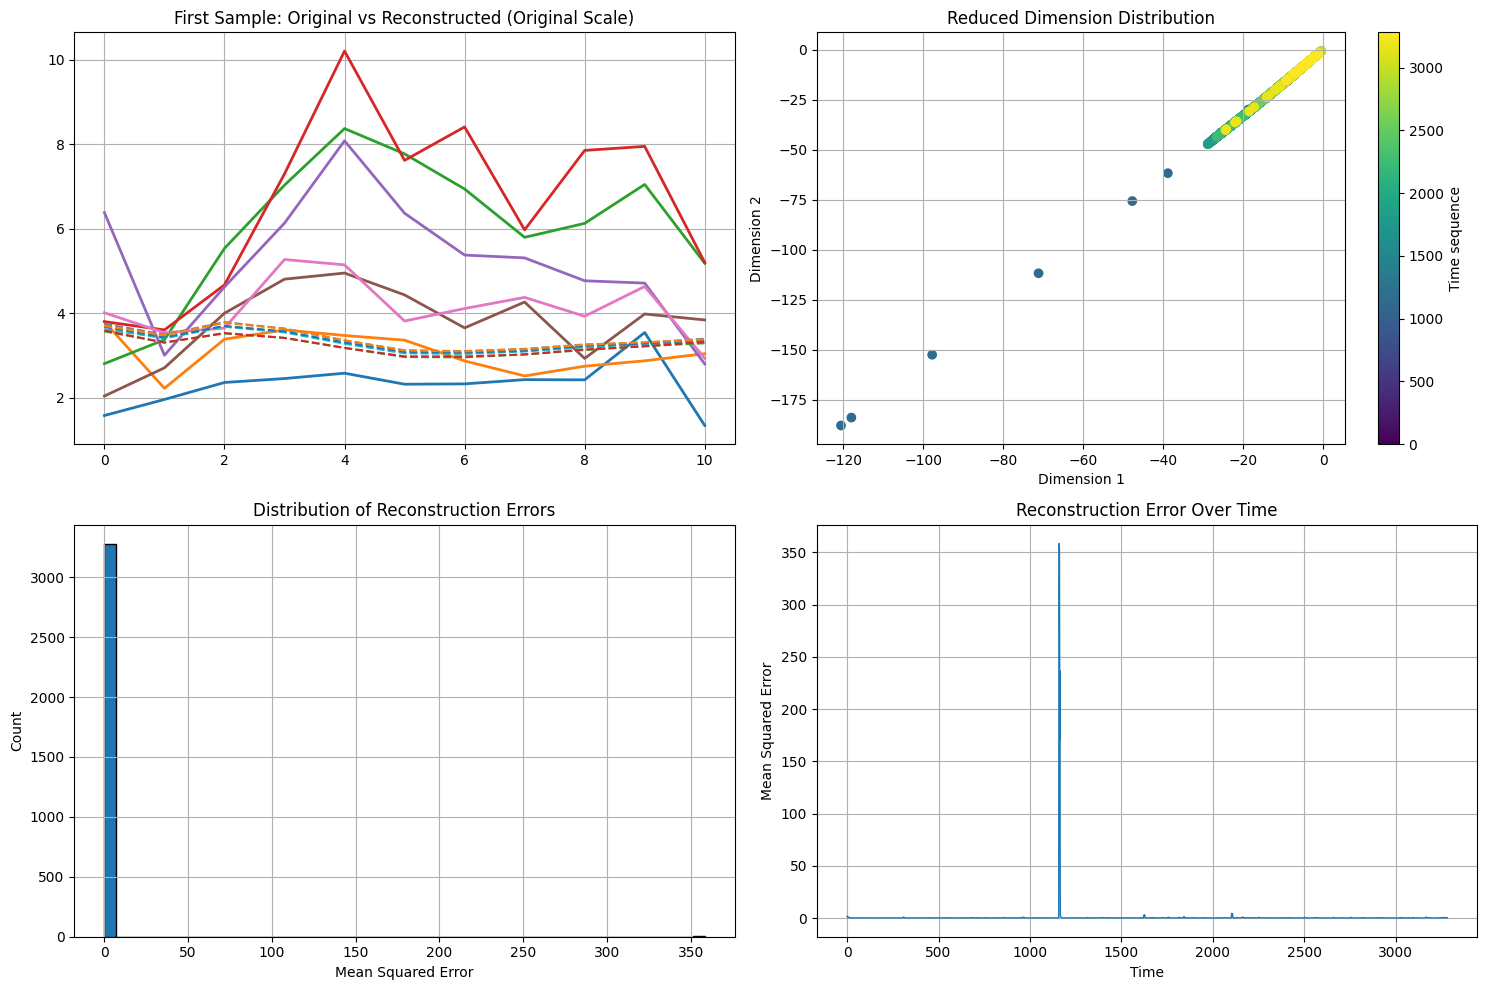


=== Autoencoder Performance Metrics (Original Scale) ===
재구성 오차 (MSE): 3.3268
재구성 오차 (RMSE): 1.8239
설명된 분산 비율: 0.1765

=== 연령대별 재구성 오차 (Original Scale) ===
연령대 1: 0.9331
연령대 2: 0.7957
연령대 3: 0.7468
연령대 4: 0.7827
연령대 5: 0.8030
연령대 6: 0.7839
연령대 7: 0.7919
연령대 8: 0.8275
연령대 9: 0.8301
연령대 10: 0.8580
연령대 11: 0.9037
| 18        | 0.1765    | 33.9      | 0.1693    | 153.9     | 4.53      | 0.04415   | 11.98     | 7.0       |
Epoch 1/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 8.2374 - val_loss: 42.6289
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0703 - val_loss: 2.7878
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6554 - val_loss: 1.3463
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6088 - val_loss: 1.5927
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4343 - val_loss: 0.8930
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0904 - val_loss: 0.7383
Epoch 7/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5872 

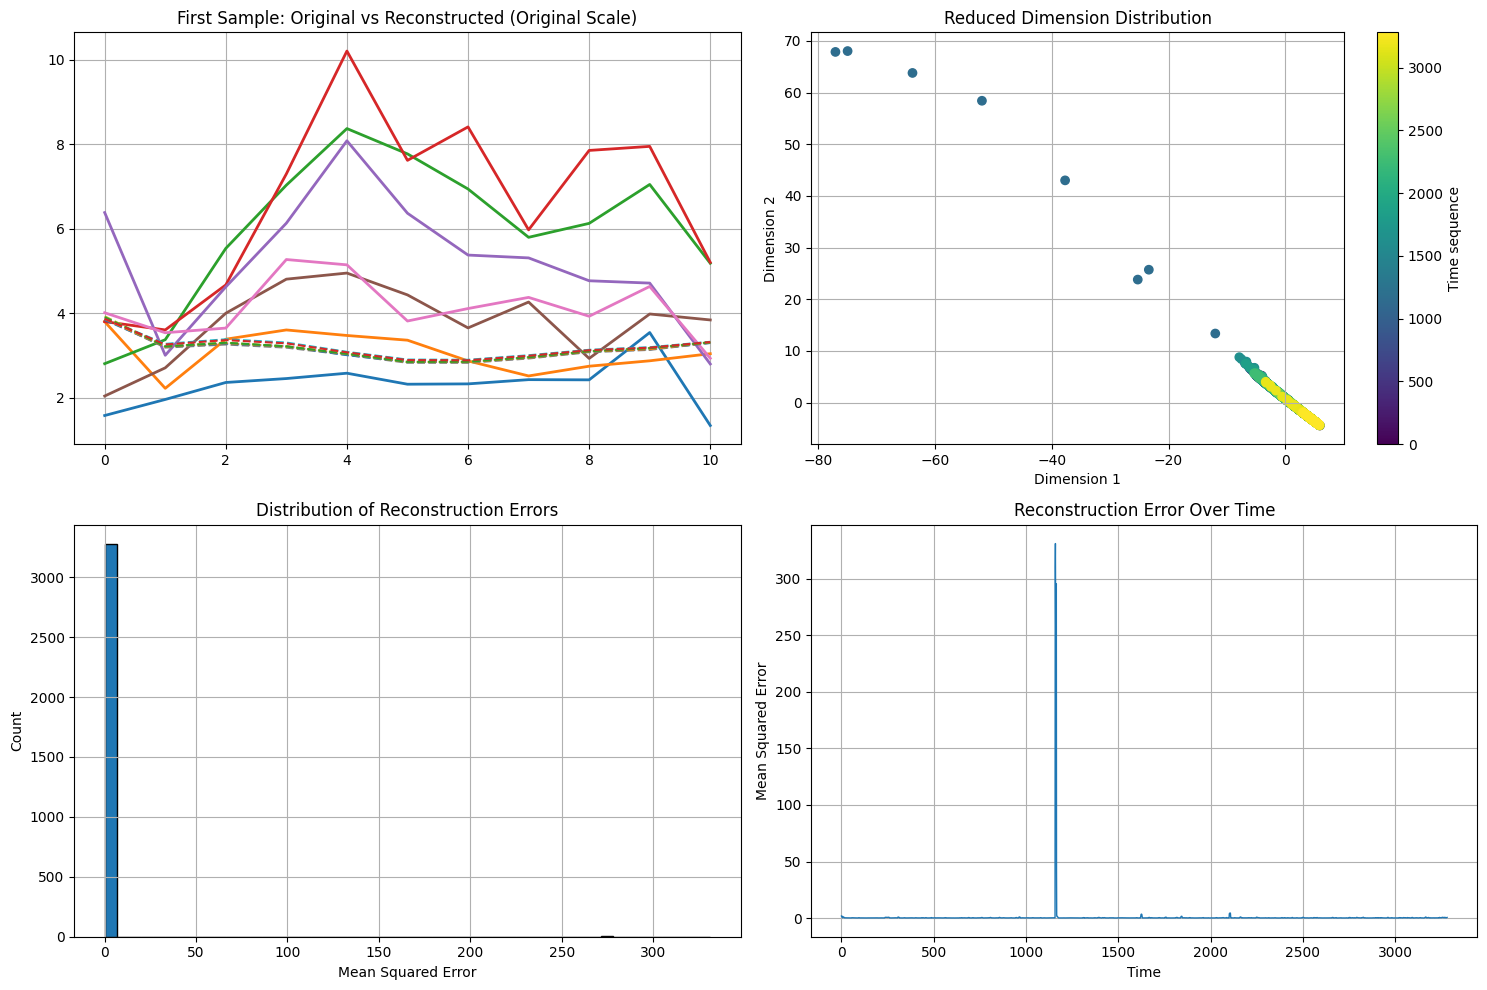


=== Autoencoder Performance Metrics (Original Scale) ===
재구성 오차 (MSE): 3.4107
재구성 오차 (RMSE): 1.8468
설명된 분산 비율: 0.1540

=== 연령대별 재구성 오차 (Original Scale) ===
연령대 1: 0.9572
연령대 2: 0.8599
연령대 3: 0.7401
연령대 4: 0.7637
연령대 5: 0.8755
연령대 6: 0.7962
연령대 7: 0.7976
연령대 8: 0.8104
연령대 9: 0.8313
연령대 10: 0.8893
연령대 11: 0.9646
| 19        | 0.154     | 38.55     | 0.1455    | 150.9     | 2.315     | 0.08515   | 7.732     | 7.0       |
Epoch 1/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.4021 - val_loss: 12.5703
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2783 - val_loss: 1.8884
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7870 - val_loss: 0.8262
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1019 - val_loss: 0.9243
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9279 - val_loss: 2.5132
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0829 - val_loss: 0.7718
Epoch 7/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8889 

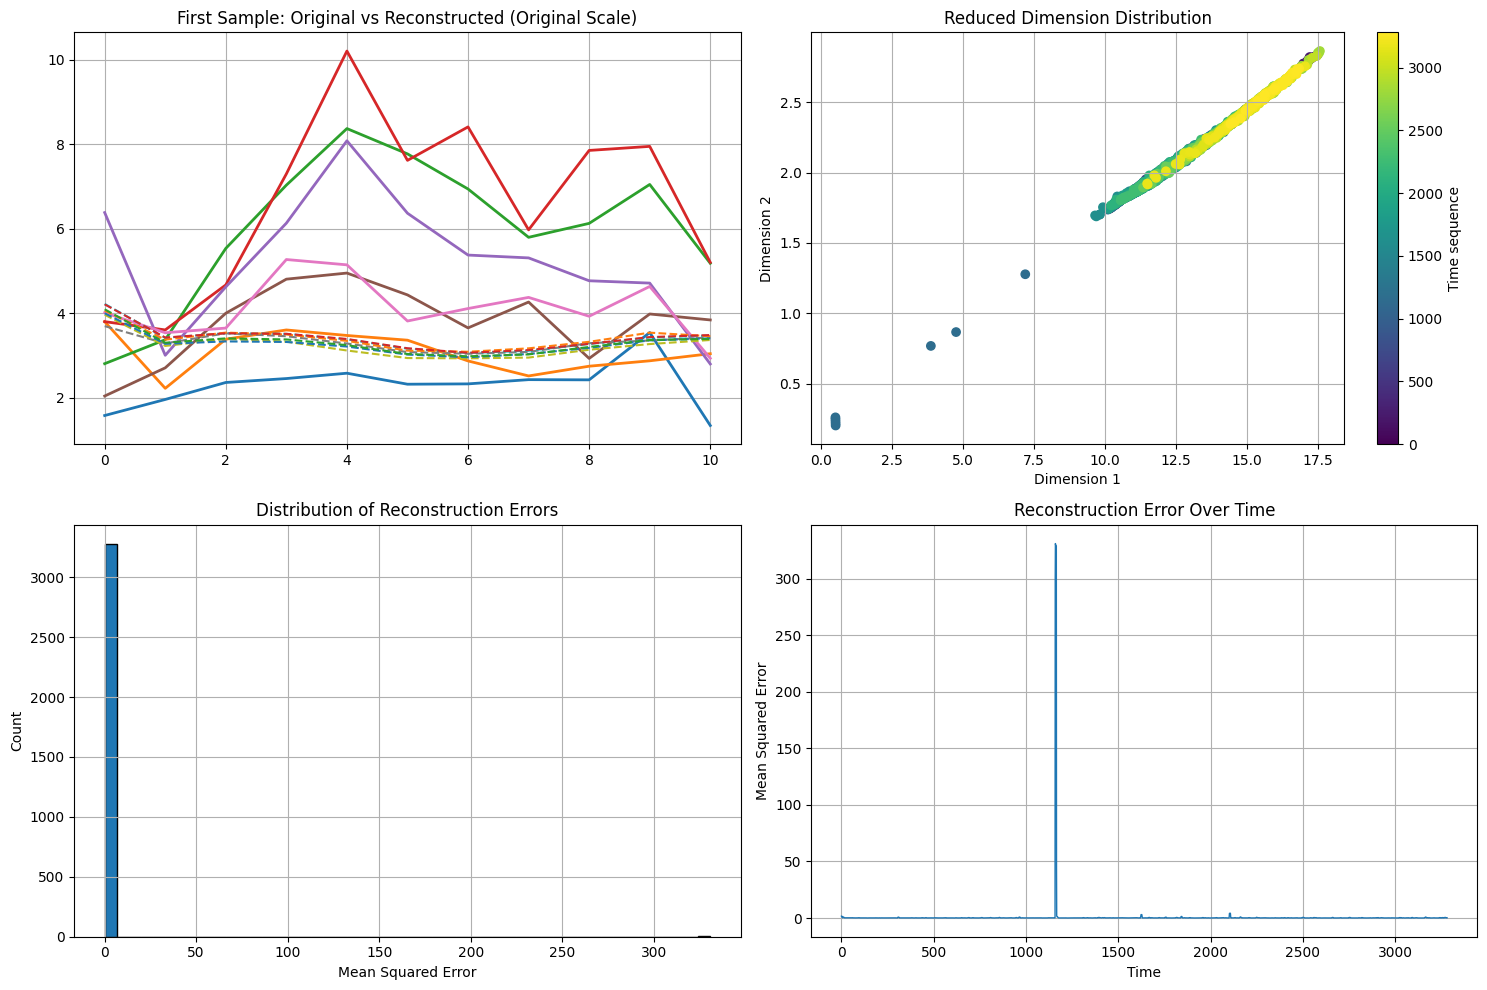


=== Autoencoder Performance Metrics (Original Scale) ===
재구성 오차 (MSE): 3.6253
재구성 오차 (RMSE): 1.9040
설명된 분산 비율: 0.1001

=== 연령대별 재구성 오차 (Original Scale) ===
연령대 1: 0.9811
연령대 2: 0.9013
연령대 3: 0.8530
연령대 4: 0.8726
연령대 5: 0.8967
연령대 6: 0.8789
연령대 7: 0.8738
연령대 8: 0.9064
연령대 9: 0.8973
연령대 10: 0.9300
연령대 11: 0.9480
| 20        | 0.1001    | 36.92     | 0.09175   | 145.2     | 4.543     | 0.02879   | 11.83     | 7.0       |
Epoch 1/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.5591 - val_loss: 6.6812
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1420 - val_loss: 1.2128
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6822 - val_loss: 0.8758
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7887 - val_loss: 0.8277
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.8626 - val_loss: 2.2544
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.9004 - val_loss: 2.0295
Epoch 7/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5241 

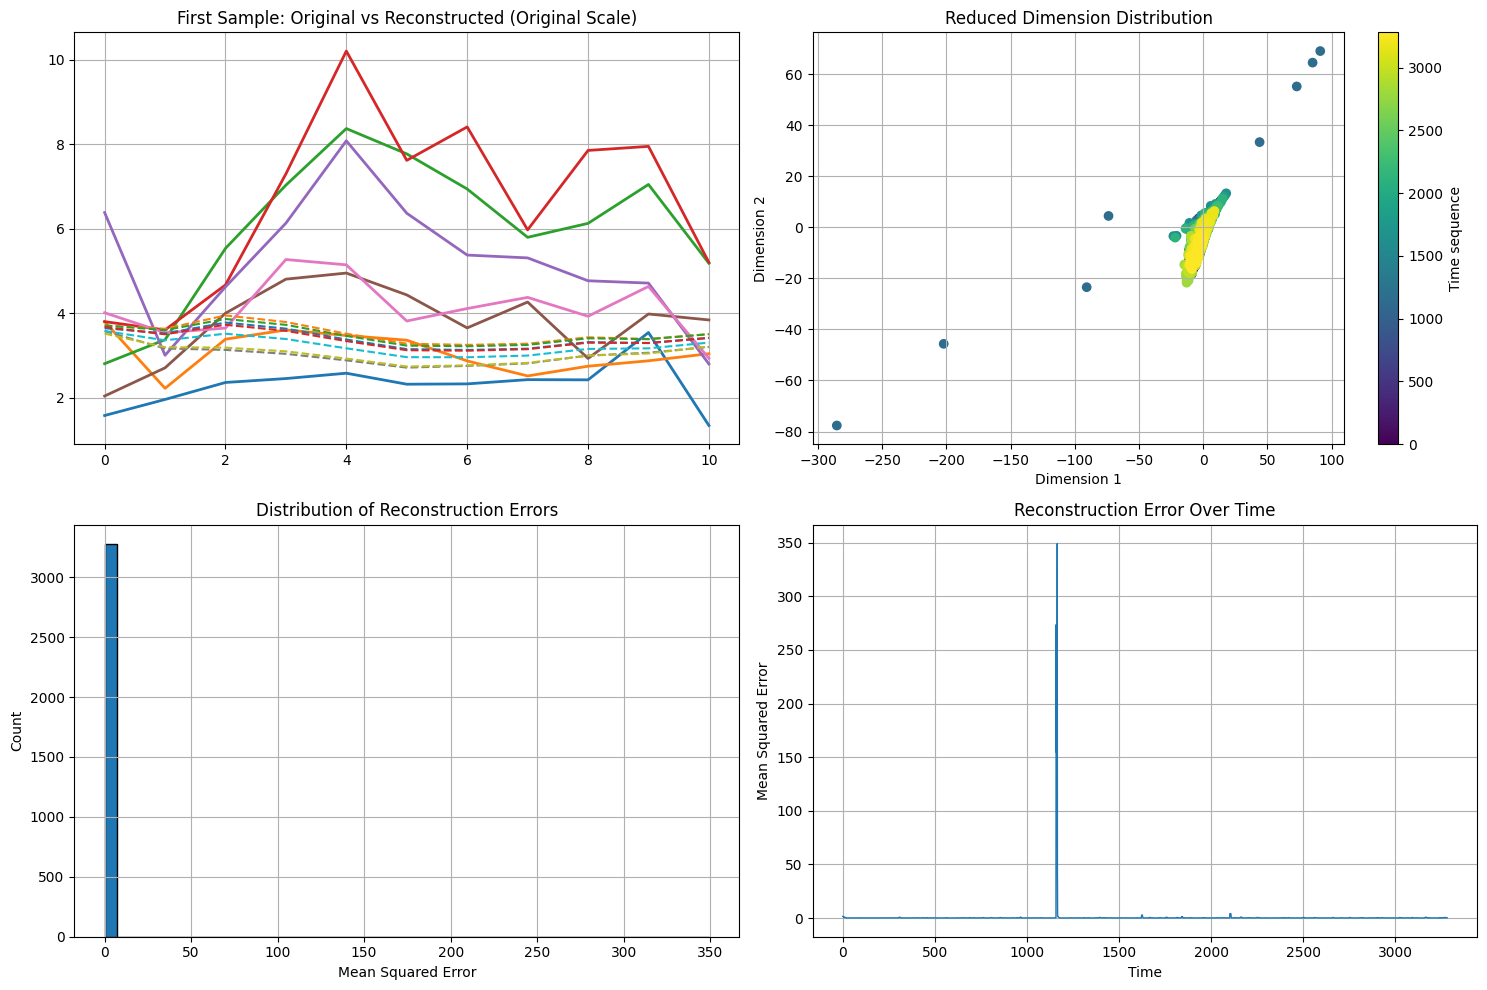


=== Autoencoder Performance Metrics (Original Scale) ===
재구성 오차 (MSE): 2.9313
재구성 오차 (RMSE): 1.7121
설명된 분산 비율: 0.2743

=== 연령대별 재구성 오차 (Original Scale) ===
연령대 1: 0.8547
연령대 2: 0.7093
연령대 3: 0.6508
연령대 4: 0.6766
연령대 5: 0.6824
연령대 6: 0.6410
연령대 7: 0.6661
연령대 8: 0.7142
연령대 9: 0.7127
연령대 10: 0.7465
연령대 11: 0.8337
| 21        | 0.2743    | 42.28     | 0.1268    | 154.7     | 4.758     | 0.02322   | 14.94     | 7.0       |
Epoch 1/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.7853 - val_loss: 10.6565
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7246 - val_loss: 0.7539
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.9045 - val_loss: 0.7554
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4540 - val_loss: 0.7224
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0096 - val_loss: 0.7357
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.2121 - val_loss: 0.8159
Epoch 7/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2191

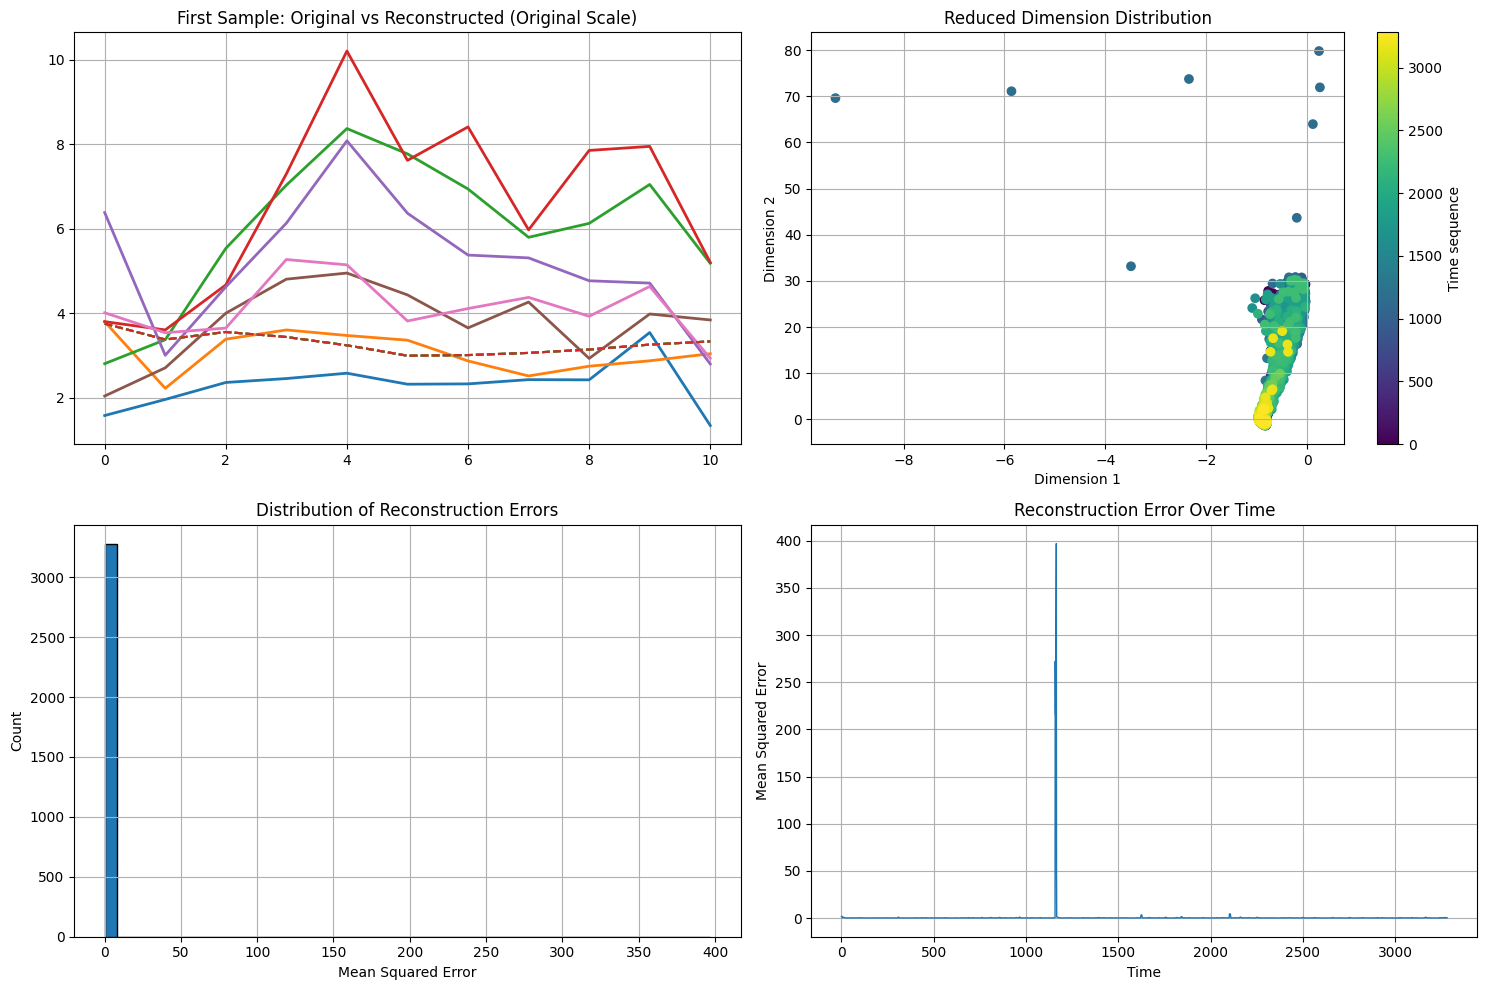


=== Autoencoder Performance Metrics (Original Scale) ===
재구성 오차 (MSE): 3.3313
재구성 오차 (RMSE): 1.8252
설명된 분산 비율: 0.1730

=== 연령대별 재구성 오차 (Original Scale) ===
연령대 1: 0.9166
연령대 2: 0.8223
연령대 3: 0.7449
연령대 4: 0.7840
연령대 5: 0.8115
연령대 6: 0.7802
연령대 7: 0.7887
연령대 8: 0.8394
연령대 9: 0.8460
연령대 10: 0.8773
연령대 11: 0.9193
| 22        | 0.173     | 42.7      | 0.3467    | 149.3     | 2.367     | 0.04501   | 16.21     | 7.0       |
Epoch 1/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 2.0411 - val_loss: 4.4264
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1531 - val_loss: 0.8907
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7878 - val_loss: 1.0265
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9696 - val_loss: 0.8935
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2281 - val_loss: 11.3856
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0473 - val_loss: 7.5261
Epoch 7/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7880

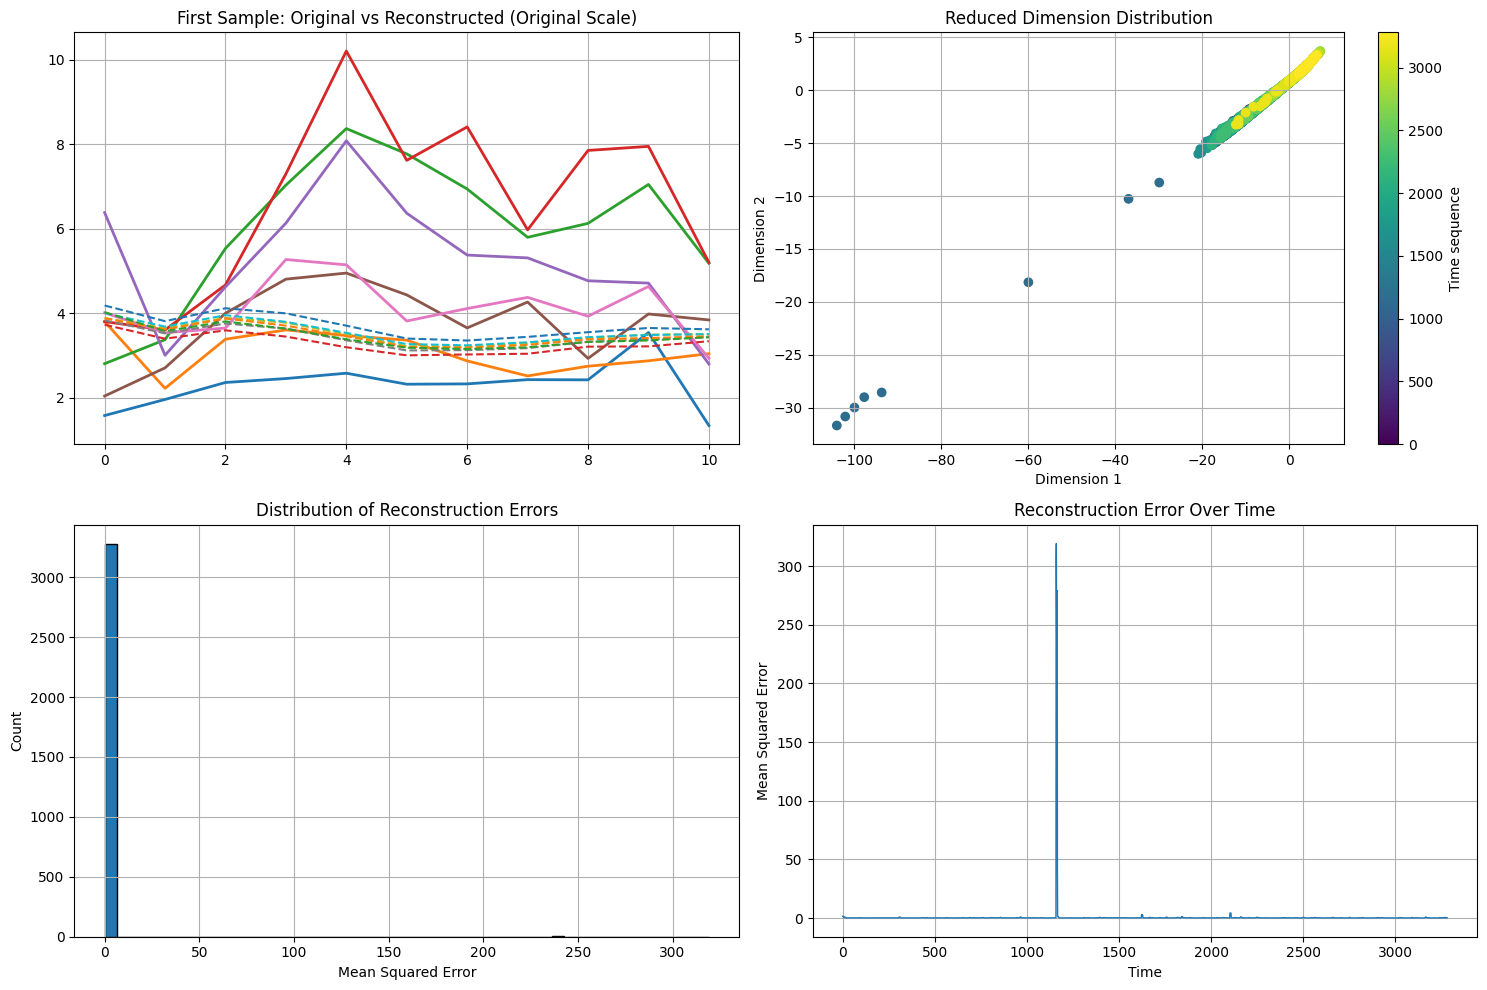


=== Autoencoder Performance Metrics (Original Scale) ===
재구성 오차 (MSE): 3.1208
재구성 오차 (RMSE): 1.7666
설명된 분산 비율: 0.2256

=== 연령대별 재구성 오차 (Original Scale) ===
연령대 1: 0.8885
연령대 2: 0.7616
연령대 3: 0.6810
연령대 4: 0.7173
연령대 5: 0.7452
연령대 6: 0.7067
연령대 7: 0.7208
연령대 8: 0.7793
연령대 9: 0.7765
연령대 10: 0.8191
연령대 11: 0.8744
| 23        | 0.2256    | 47.99     | 0.1889    | 153.7     | 2.617     | 0.02573   | 9.208     | 7.0       |
Epoch 1/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 3.4212 - val_loss: 7.3143
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8007 - val_loss: 2.6637
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0731 - val_loss: 0.7465
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0659 - val_loss: 1.1576
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9489 - val_loss: 0.7672
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7649 - val_loss: 1.9013
Epoch 7/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.477

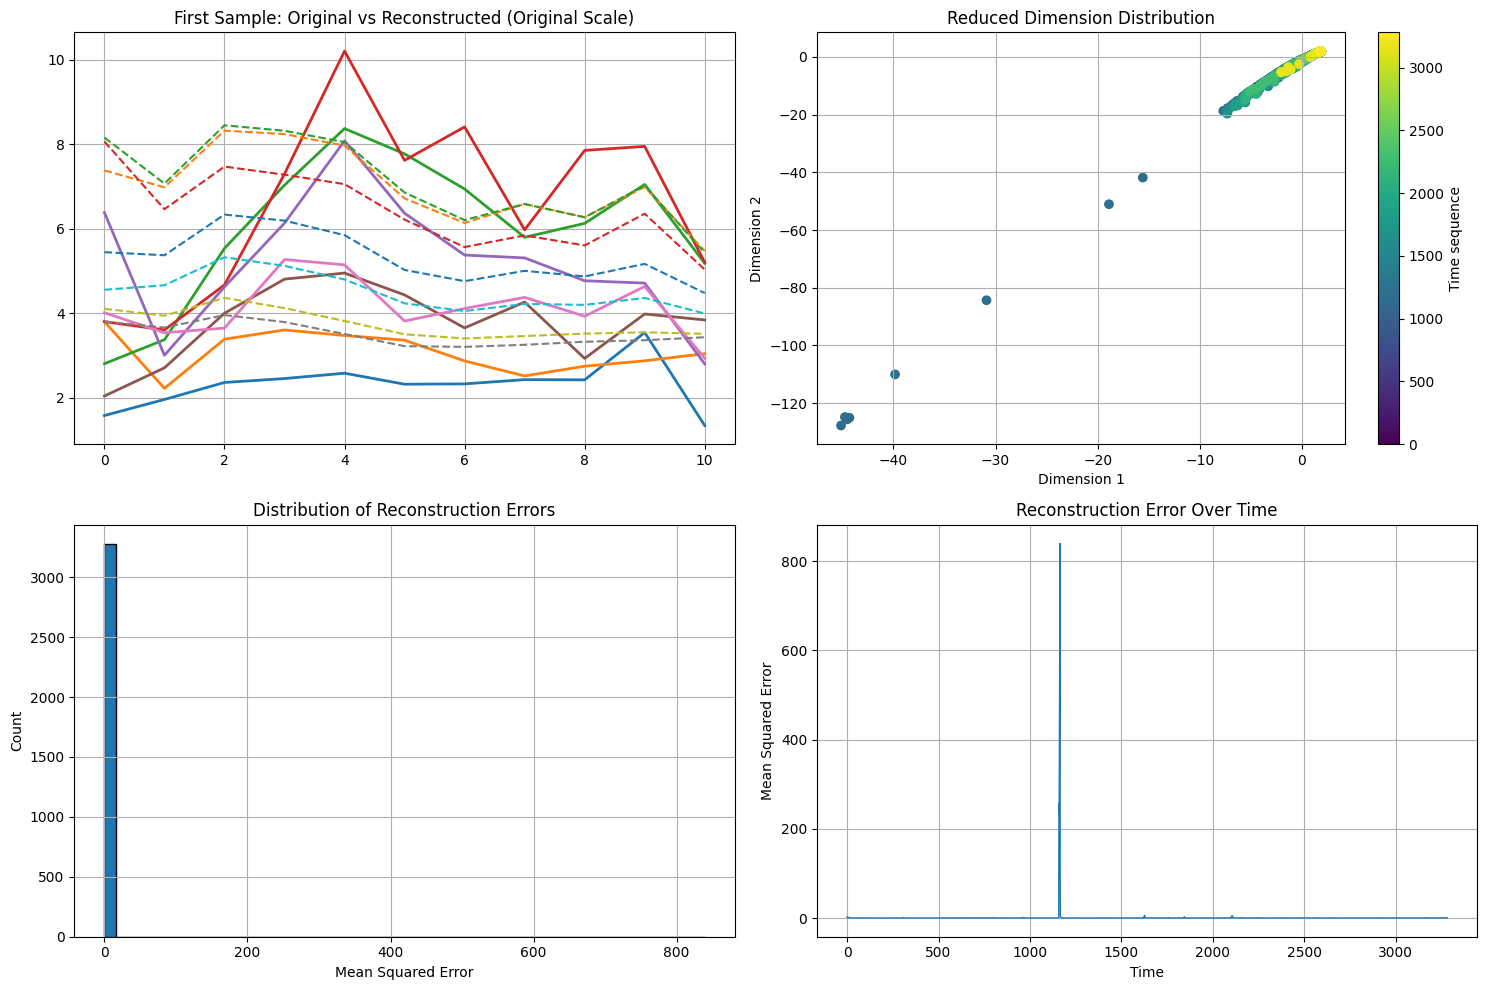


=== Autoencoder Performance Metrics (Original Scale) ===
재구성 오차 (MSE): 4.7733
재구성 오차 (RMSE): 2.1848
설명된 분산 비율: -0.1848

=== 연령대별 재구성 오차 (Original Scale) ===
연령대 1: 1.0647
연령대 2: 1.3949
연령대 3: 1.1576
연령대 4: 1.2274
연령대 5: 1.2228
연령대 6: 1.4278
연령대 7: 1.1996
연령대 8: 1.1912
연령대 9: 1.2771
연령대 10: 1.4591
연령대 11: 1.1148
| 24        | -0.1848   | 50.19     | 0.1635    | 152.7     | 4.439     | 0.05742   | 15.93     | 7.0       |
Epoch 1/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 5.0106 - val_loss: 8.8082
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1197 - val_loss: 0.9671
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.1437 - val_loss: 0.8295
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.8705 - val_loss: 0.7921
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9668 - val_loss: 0.7849
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7436 - val_loss: 0.7887
Epoch 7/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0834

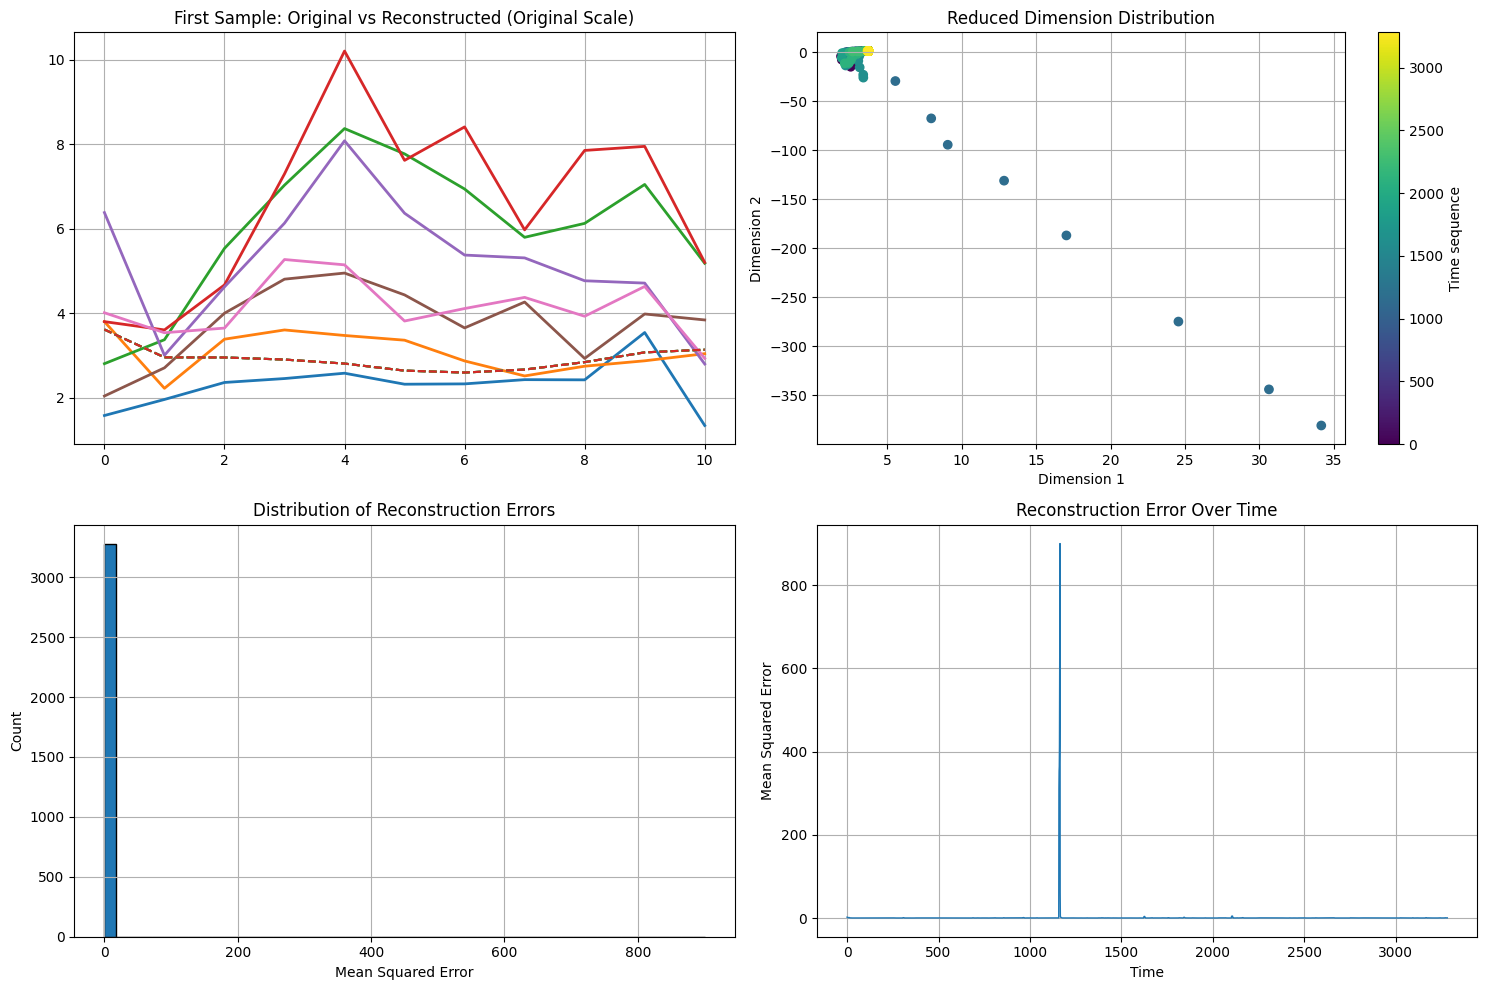


=== Autoencoder Performance Metrics (Original Scale) ===
재구성 오차 (MSE): 5.6687
재구성 오차 (RMSE): 2.3809
설명된 분산 비율: -0.4069

=== 연령대별 재구성 오차 (Original Scale) ===
연령대 1: 1.5057
연령대 2: 1.0514
연령대 3: 1.1959
연령대 4: 2.0901
연령대 5: 1.0777
연령대 6: 1.2167
연령대 7: 1.2614
연령대 8: 1.0629
연령대 9: 0.9476
연령대 10: 2.3267
연령대 11: 1.2818
| 25        | -0.4069   | 43.16     | 0.2708    | 157.5     | 2.947     | 0.09739   | 9.252     | 7.0       |

최적화된 하이퍼파라미터:
설명된 분산 점수: 0.3431
batch_size: 41
dropout_rate: 0.0328
epochs: 141
latent_dim: 2
learning_rate: 0.0066
patience: 38
window_size: 7
Epoch 1/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 1.0021 - val_loss: 0.7244
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.3153 - val_loss: 0.7981
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.2572 - val_loss: 1.0545
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9820 - val_loss: 1.8035
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8329 - val_loss: 8.1590
E

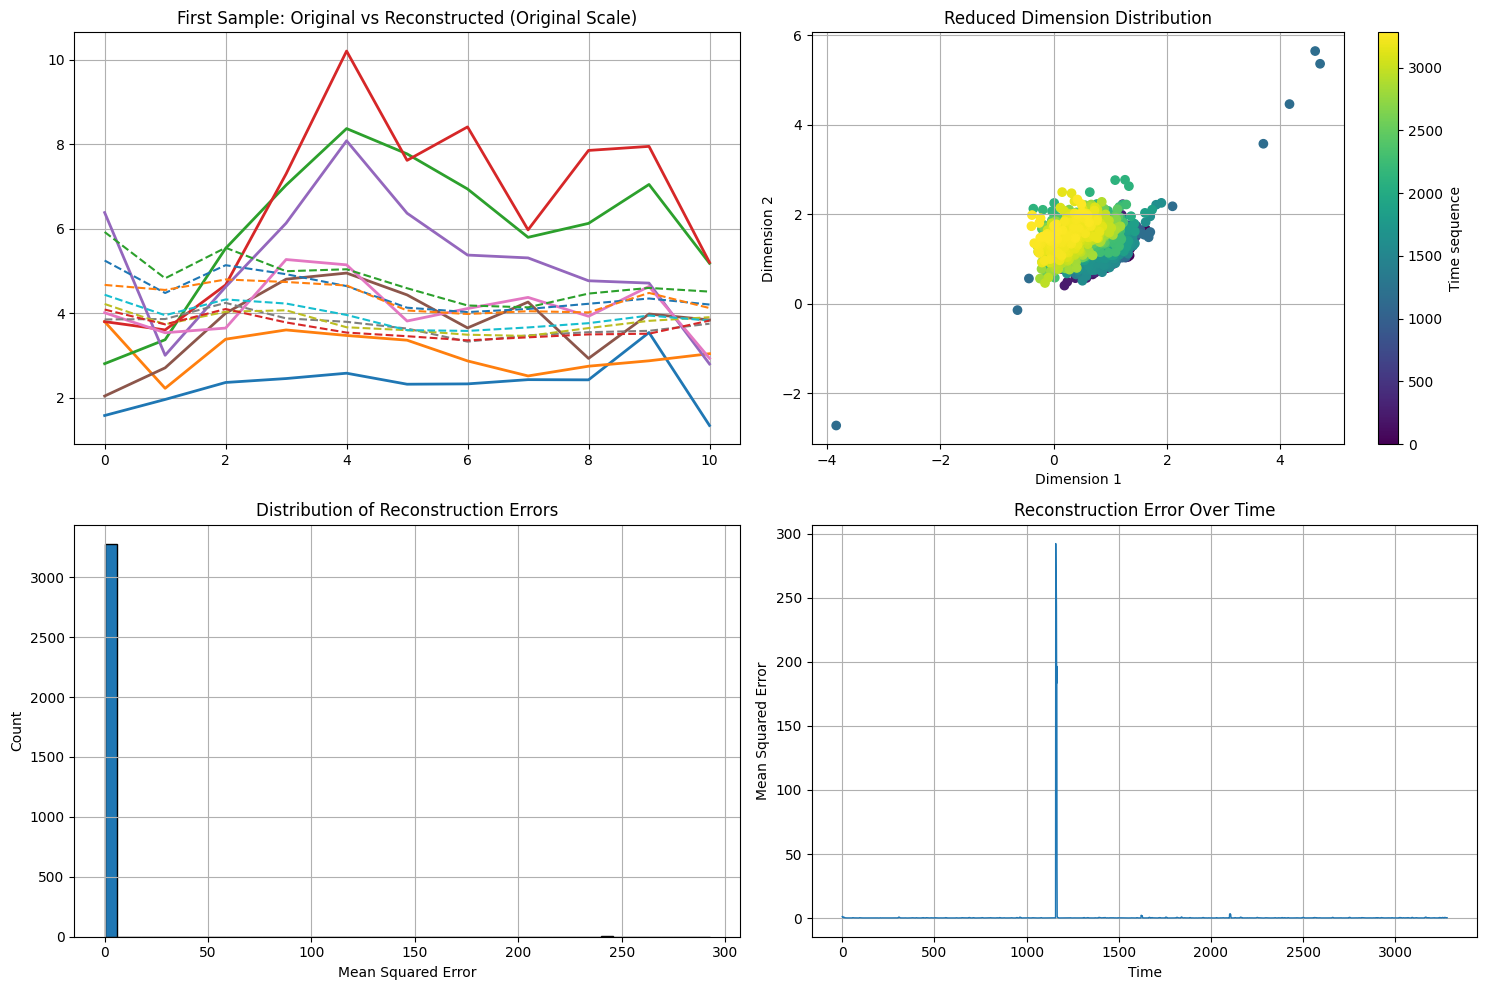


=== Autoencoder Performance Metrics (Original Scale) ===
재구성 오차 (MSE): 2.8786
재구성 오차 (RMSE): 1.6967
설명된 분산 비율: 0.2907

=== 연령대별 재구성 오차 (Original Scale) ===
연령대 1: 0.8291
연령대 2: 0.7157
연령대 3: 0.6316
연령대 4: 0.6649
연령대 5: 0.6828
연령대 6: 0.6413
연령대 7: 0.6612
연령대 8: 0.7174
연령대 9: 0.7040
연령대 10: 0.7324
연령대 11: 0.7937

데이터 차원 정보:
원본 데이터 차원: (3282, 7, 11)
축소된 데이터 차원: (3282, 5)

축소된 데이터가 'nst_salmon_autoencoded.csv'에 저장되었습니다.


In [42]:
if __name__ == "__main__":
    # CSV 파일 로드
    df = pd.read_csv('../../data/raw/nst_연어_trend_2025-01-17.csv')
    
    # 최적화할 파라미터 범위 정의
    pbounds = {
        'latent_dim': (2, 5),           # 2~5 차원
        'epochs': (50, 200),            # 50~200 에폭
        'batch_size': (8, 64),          # 배치 사이즈 8~64
        'window_size': (7, 7),         # 윈도우 크기 5~14일
        'dropout_rate': (0.01, 0.5),     # 드롭아웃 비율 0.1~0.5
        'patience': (5, 40),            # patience 5~20
        'learning_rate': (0.0001, 0.1)  # 학습률 0.0001~0.01
    }
    
    # 베이지안 최적화 객체 생성
    optimizer = BayesianOptimization(
        f=optimize_model,
        pbounds=pbounds,
        random_state=42
    )
    
    # 최적화 실행
    optimizer.maximize(
        init_points=5,    # 초기 랜덤 탐색 횟수
        n_iter=20         # 최적화 반복 횟수
    )
    
    # 최적의 파라미터 추출 및 전역 변수 업데이트
    best_params = optimizer.max['params']
    a_latent_dim = int(best_params['latent_dim'])
    a_epoch = int(best_params['epochs'])
    a_batch_size = int(best_params['batch_size'])
    a_window_size = int(best_params['window_size'])
    a_dropout_rate = best_params['dropout_rate']
    a_patience = int(best_params['patience'])
    a_learning_rate = best_params['learning_rate']
    
    # 최적의 파라미터 출력
    print("\n최적화된 하이퍼파라미터:")
    print(f"설명된 분산 점수: {optimizer.max['target']:.4f}")
    for param, value in best_params.items():
        if param in ['latent_dim', 'epochs', 'batch_size', 'window_size', 'patience']:
            print(f"{param}: {int(value)}")
        else:
            print(f"{param}: {value:.4f}")
    
    # 최적의 파라미터로 데이터 전처리 및 모델 학습
    processed_data, scaler = prepare_data(df)
    
    # 차원 축소 수행
    reduced_data, model = train_and_reduce(processed_data)
    
    # 성능 평가 실행
    results = evaluate_autoencoder_performance(processed_data, reduced_data, model, scaler)

    # 데이터 차원 출력
    print("\n데이터 차원 정보:")
    print(f"원본 데이터 차원: {processed_data.shape}")
    print(f"축소된 데이터 차원: {reduced_data.shape}")

    # 데이터 저장
    reduced_df = pd.DataFrame(
        reduced_data, 
        columns=[f'salmon_dim_{i+1}' for i in range(reduced_data.shape[1])]
    )
    reduced_df['date'] = df['date'].iloc[a_window_size-1:].reset_index(drop=True)
    reduced_df.to_csv('nst_salmon_autoencoded.csv', index=False)
    
    print("\n축소된 데이터가 'nst_salmon_autoencoded.csv'에 저장되었습니다.")
    
	

### 데이터 저장

In [43]:
# import pandas as pd
# import numpy as np

# # window_size 정의
# window_size = a_window_size  # 이전에 사용한 윈도우 크기

# # reduced_data를 DataFrame으로 변환
# # 각 컬럼은 축소된 차원을 나타냄
# reduced_df = pd.DataFrame(
#     reduced_data,
#     columns=[f'salmon_dim_{i+1}' for i in range(reduced_data.shape[1])]
# )

# # 원본 데이터의 날짜 정보 추가 (있다면)
# reduced_df['date'] = df['date'].iloc[window_size-1:].reset_index(drop=True)

# # CSV 파일로 저장
# reduced_df.to_csv('nst_salmon_autoencoded.csv', index=False)

# # 저장된 것 확인
# print("저장된 데이터 미리보기:")
# print(reduced_df.head())